# Creating pipeline for video/images of lane lines

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import scipy
from scipy import signal
from collections import deque
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]    

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels

def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M


def find_peaks(img,thresh):
    img_half=img[img.shape[0]//2:,:,0]
    data = np.sum(img_half, axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(data,20)
    xs = np.arange(len(filtered))
    peak_ind = signal.find_peaks_cwt(filtered, np.arange(20,300))
    peaks = np.array(peak_ind)
    peaks = peaks[filtered[peak_ind]>thresh]
    return peaks,filtered


def get_next_window(img,center_point,width):
    """
    input: img,center_point,width
        img: binary 3 channel image
        center_point: center of window
        width: width of window
    
    output: masked,center_point
        masked : a masked image of the same size. mask is a window centered at center_point
        center : the mean ofall pixels found within the window
    """
    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def lane_from_window(binary,center_point,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_window(zones[0],center_point,width)
    
    for zone in zones[1:]:
        next_window,center = get_next_window(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window


# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def set_current_fit_xvals(self):
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
    def add_data(self):
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
            
    def set_avgcoeffs(self):
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def set_allxy(self,lane_candidate):
        self.ally,self.allx = (lane_candidate[:,:,0]>254).nonzero()

    def set_current_fit_coeffs(self):
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
    
    def get_diffs(self):
        if self.n_buffered>0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 
            
    def set_radius_of_curvature(self):
        # Define y-value where we want radius of curvature in meters (choose bottom of the image)
        '''Using an adaptation of the formula given in the lessons
            ym_per_pix = 30/720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension
            left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2) #Because we only need the left side here
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        '''
        y_eval = max(self.fit_yvals)
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700
        left_fit_cr = np.polyfit(self.fit_yvals*ym_per_pix, self.fit_yvals*xm_per_pix, 2)
        if self.avg_fit_coeffs is not None:
            self.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
                        
            
    def set_line_base_pos(self):
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):
        self.set_allxy(lane)
        self.set_current_fit_coeffs()
        self.set_current_fit_xvals()
        self.set_radius_of_curvature()
        self.set_line_base_pos()
        self.get_diffs()
        if self.accept_lane():
            self.detected=True
            self.add_data()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected=False            
            self.pop_data()
            if self.n_buffered>0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected,self.n_buffered
    
def get_binary_lane_image(img,line,window_center,width=300):
    if line.detected:
        window_center=line.line_pos
    else:
        peaks,filtered = find_peaks(img,thresh=3000)
        if len(peaks)!=2:
            print('Trouble ahead! Pull Over! '+ str(len(peaks)) +' lanes detected!')
            plt.imsave('troublesome_image.jpg',img)                        
            
        peak_ind = np.argmin(abs(peaks-window_center))
        peak  = peaks[peak_ind]
        window_center = peak
    
    lane_binary = lane_from_window(img,window_center,width)
    return lane_binary 


def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    undist = undistort(img)    
    unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def process_image(img):
    global left
    global right
    undist = undistort(img)
    binary,_  = binarize(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    
    window_center_l = 340
    if left.detected:
        window_center_l = left.line_pos        
    left_binary = get_binary_lane_image(warped_binary,left,window_center_l,width=300)
    
    window_center_r = 940
    if right.detected:
        window_center_r = right.line_pos        
    right_binary = get_binary_lane_image(warped_binary,right,window_center_r,width=300)
    
    detected_l,n_buffered_left = left.update(left_binary)
    detected_r,n_buffered_right = right.update(right_binary)    
    
    left_fitx = left.avgx
    right_fitx = right.avgx
    yvals = left.fit_yvals
    lane_width = 3.7
    off_center = -100*round(0.5*(right.line_base_pos-lane_width/2) +  0.5*(abs(left.line_base_pos)-lane_width/2),2)
    
    result = project_lane_lines(img,left_fitx,right_fitx,yvals)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(430,630), font, 1,(0,0,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        curvature = 0.5*(round(right.radius_of_curvature/100**7.5,2) + round(left.radius_of_curvature/100**7.5,2))
        print(curvature)
        str2 = str('radius of curvature: '+str(curvature)+'m')
        cv2.putText(result,str2,(430,670), font, 1,(0,0,255),2,cv2.LINE_AA)    
    
    return result

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


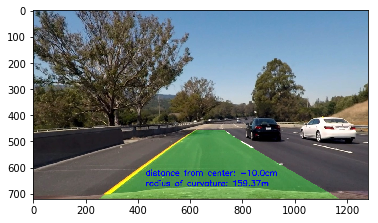

In [2]:
left = Line(7)
right = Line(7)
img = plt.imread('test_images/test6.jpg')
result = process_image(img)
result = process_image(img)

plt.figure()
plt.imshow(result)
plt.show()

In [3]:
left = Line(7)
right = Line(7)

out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

159.37


  0%|                                                                                 | 1/1261 [00:00<04:34,  4.59it/s]

159.37


  0%|▏                                                                                | 2/1261 [00:00<04:28,  4.69it/s]

159.37


  0%|▏                                                                                | 3/1261 [00:00<04:20,  4.83it/s]

159.37


  0%|▎                                                                                | 4/1261 [00:00<04:12,  4.97it/s]

159.37


  0%|▎                                                                                | 5/1261 [00:00<04:06,  5.10it/s]

159.37


  0%|▍                                                                                | 6/1261 [00:01<04:03,  5.15it/s]

159.37


  1%|▍                                                                                | 7/1261 [00:01<04:00,  5.22it/s]

159.37


  1%|▌                                                                                | 8/1261 [00:01<03:57,  5.28it/s]

159.37


  1%|▌                                                                                | 9/1261 [00:01<03:55,  5.32it/s]

159.37


  1%|▋                                                                               | 10/1261 [00:01<03:54,  5.33it/s]

159.37


  1%|▋                                                                               | 11/1261 [00:02<03:53,  5.36it/s]

159.37


  1%|▊                                                                               | 12/1261 [00:02<03:52,  5.38it/s]

159.37


  1%|▊                                                                               | 13/1261 [00:02<03:52,  5.37it/s]

fit coeffs too far off [%] [ 0.97479316  0.29954646 -0.01559499]
159.37


  1%|▉                                                                               | 14/1261 [00:02<03:56,  5.28it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.95997305  0.3640373  -0.03660286]
159.37


  1%|▉                                                                               | 15/1261 [00:03<05:17,  3.92it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.84499672  0.36318004 -0.04946569]
159.37


  1%|█                                                                               | 16/1261 [00:03<06:29,  3.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.71282069  0.33314955 -0.05052543]
159.37


  1%|█                                                                               | 17/1261 [00:03<07:27,  2.78it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.04396935  0.45540377 -0.06208363]
159.37


  1%|█▏                                                                              | 18/1261 [00:04<08:05,  2.56it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.89781472  0.41164268 -0.05520026]
159.37


  2%|█▏                                                                              | 19/1261 [00:04<08:17,  2.50it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.07987544  0.38852824 -0.04433765]
159.37


  2%|█▎                                                                              | 20/1261 [00:05<08:26,  2.45it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


  2%|█▎                                                                              | 21/1261 [00:05<08:30,  2.43it/s]

159.37


  2%|█▍                                                                              | 22/1261 [00:05<07:07,  2.90it/s]

159.37


  2%|█▍                                                                              | 23/1261 [00:06<06:13,  3.32it/s]

159.37


  2%|█▌                                                                              | 24/1261 [00:06<05:30,  3.74it/s]

159.37


  2%|█▌                                                                              | 25/1261 [00:06<05:01,  4.10it/s]

159.37


  2%|█▋                                                                              | 26/1261 [00:06<04:39,  4.41it/s]

159.37


  2%|█▋                                                                              | 27/1261 [00:06<04:25,  4.65it/s]

159.37


  2%|█▊                                                                              | 28/1261 [00:07<04:14,  4.85it/s]

159.37


  2%|█▊                                                                              | 29/1261 [00:07<04:06,  4.99it/s]

159.37


  2%|█▉                                                                              | 30/1261 [00:07<04:00,  5.12it/s]

159.37


  2%|█▉                                                                              | 31/1261 [00:07<04:00,  5.12it/s]

159.37


  3%|██                                                                              | 32/1261 [00:07<03:57,  5.18it/s]

159.37


  3%|██                                                                              | 33/1261 [00:07<03:56,  5.20it/s]

159.37


  3%|██▏                                                                             | 34/1261 [00:08<03:52,  5.27it/s]

159.37


  3%|██▏                                                                             | 35/1261 [00:08<03:58,  5.14it/s]

159.37


  3%|██▎                                                                             | 36/1261 [00:08<03:57,  5.15it/s]

159.37


  3%|██▎                                                                             | 37/1261 [00:08<03:56,  5.18it/s]

159.37


  3%|██▍                                                                             | 38/1261 [00:08<04:00,  5.08it/s]

159.37


  3%|██▍                                                                             | 39/1261 [00:09<04:00,  5.08it/s]

159.37


  3%|██▌                                                                             | 40/1261 [00:09<04:03,  5.02it/s]

159.37


  3%|██▌                                                                             | 41/1261 [00:09<04:02,  5.04it/s]

159.37


  3%|██▋                                                                             | 42/1261 [00:09<03:57,  5.14it/s]

159.37


  3%|██▋                                                                             | 43/1261 [00:09<04:08,  4.91it/s]

159.37


  3%|██▊                                                                             | 44/1261 [00:10<04:00,  5.06it/s]

159.37


  4%|██▊                                                                             | 45/1261 [00:10<03:55,  5.15it/s]

159.37


  4%|██▉                                                                             | 46/1261 [00:10<03:54,  5.18it/s]

159.37


  4%|██▉                                                                             | 47/1261 [00:10<04:00,  5.05it/s]

159.37


  4%|███                                                                             | 48/1261 [00:10<04:01,  5.03it/s]

159.37


  4%|███                                                                             | 49/1261 [00:11<04:04,  4.96it/s]

159.37


  4%|███▏                                                                            | 50/1261 [00:11<04:06,  4.91it/s]

159.37


  4%|███▏                                                                            | 51/1261 [00:11<04:02,  5.00it/s]

159.37


  4%|███▎                                                                            | 52/1261 [00:11<03:55,  5.13it/s]

159.37


  4%|███▎                                                                            | 53/1261 [00:11<03:55,  5.12it/s]

159.37


  4%|███▍                                                                            | 54/1261 [00:12<03:54,  5.14it/s]

159.37


  4%|███▍                                                                            | 55/1261 [00:12<03:55,  5.13it/s]

159.37


  4%|███▌                                                                            | 56/1261 [00:12<03:55,  5.12it/s]

159.37


  5%|███▌                                                                            | 57/1261 [00:12<04:02,  4.96it/s]

159.37


  5%|███▋                                                                            | 58/1261 [00:12<04:01,  4.97it/s]

159.37


  5%|███▋                                                                            | 59/1261 [00:13<04:11,  4.78it/s]

159.37


  5%|███▊                                                                            | 60/1261 [00:13<04:15,  4.70it/s]

159.37


  5%|███▊                                                                            | 61/1261 [00:13<04:13,  4.74it/s]

159.37


  5%|███▉                                                                            | 62/1261 [00:13<04:10,  4.79it/s]

159.37


  5%|███▉                                                                            | 63/1261 [00:14<04:16,  4.67it/s]

159.37


  5%|████                                                                            | 64/1261 [00:14<04:20,  4.59it/s]

159.37


  5%|████                                                                            | 65/1261 [00:14<04:17,  4.64it/s]

159.37


  5%|████▏                                                                           | 66/1261 [00:14<04:16,  4.66it/s]

159.37


  5%|████▎                                                                           | 67/1261 [00:14<04:09,  4.79it/s]

159.37


  5%|████▎                                                                           | 68/1261 [00:15<04:05,  4.86it/s]

159.37


  5%|████▍                                                                           | 69/1261 [00:15<04:03,  4.90it/s]

159.37


  6%|████▍                                                                           | 70/1261 [00:15<03:58,  4.99it/s]

159.37


  6%|████▌                                                                           | 71/1261 [00:15<04:04,  4.86it/s]

159.37


  6%|████▌                                                                           | 72/1261 [00:15<04:01,  4.92it/s]

159.37


  6%|████▋                                                                           | 73/1261 [00:16<03:59,  4.95it/s]

fit coeffs too far off [%] [ 0.85768444  0.28897794 -0.01218818]
159.37


  6%|████▋                                                                           | 74/1261 [00:16<04:00,  4.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


  6%|████▊                                                                           | 75/1261 [00:16<05:15,  3.76it/s]

159.37


  6%|████▊                                                                           | 76/1261 [00:16<04:52,  4.04it/s]

159.37


  6%|████▉                                                                           | 77/1261 [00:17<04:31,  4.36it/s]

159.37


  6%|████▉                                                                           | 78/1261 [00:17<04:22,  4.50it/s]

159.37


  6%|█████                                                                           | 79/1261 [00:17<04:12,  4.68it/s]

159.37


  6%|█████                                                                           | 80/1261 [00:17<04:04,  4.84it/s]

159.37


  6%|█████▏                                                                          | 81/1261 [00:17<04:02,  4.87it/s]

159.37


  7%|█████▏                                                                          | 82/1261 [00:18<04:02,  4.86it/s]

159.37


  7%|█████▎                                                                          | 83/1261 [00:18<03:58,  4.93it/s]

fit coeffs too far off [%] [-0.91797737 -0.46489173  0.04298614]
159.37


  7%|█████▎                                                                          | 84/1261 [00:18<04:00,  4.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


  7%|█████▍                                                                          | 85/1261 [00:18<05:17,  3.71it/s]

159.37


  7%|█████▍                                                                          | 86/1261 [00:19<04:47,  4.08it/s]

159.37


  7%|█████▌                                                                          | 87/1261 [00:19<04:30,  4.35it/s]

159.37


  7%|█████▌                                                                          | 88/1261 [00:19<04:17,  4.55it/s]

159.37


  7%|█████▋                                                                          | 89/1261 [00:19<04:12,  4.65it/s]

159.37


  7%|█████▋                                                                          | 90/1261 [00:19<04:07,  4.74it/s]

159.37


  7%|█████▊                                                                          | 91/1261 [00:20<04:04,  4.79it/s]

159.37


  7%|█████▊                                                                          | 92/1261 [00:20<04:03,  4.80it/s]

159.37


  7%|█████▉                                                                          | 93/1261 [00:20<03:56,  4.93it/s]

159.37


  7%|█████▉                                                                          | 94/1261 [00:20<03:52,  5.01it/s]

159.37


  8%|██████                                                                          | 95/1261 [00:20<03:49,  5.07it/s]

159.37


  8%|██████                                                                          | 96/1261 [00:21<03:48,  5.09it/s]

159.37


  8%|██████▏                                                                         | 97/1261 [00:21<03:50,  5.06it/s]

159.37


  8%|██████▏                                                                         | 98/1261 [00:21<03:45,  5.15it/s]

159.37


  8%|██████▎                                                                         | 99/1261 [00:21<03:42,  5.22it/s]

159.37


  8%|██████▎                                                                        | 100/1261 [00:21<03:42,  5.23it/s]

159.37


  8%|██████▎                                                                        | 101/1261 [00:22<03:38,  5.31it/s]

159.37


  8%|██████▍                                                                        | 102/1261 [00:22<03:43,  5.19it/s]

159.37


  8%|██████▍                                                                        | 103/1261 [00:22<03:46,  5.12it/s]

159.37


  8%|██████▌                                                                        | 104/1261 [00:22<03:44,  5.15it/s]

159.37


  8%|██████▌                                                                        | 105/1261 [00:22<03:44,  5.15it/s]

159.37


  8%|██████▋                                                                        | 106/1261 [00:23<03:45,  5.11it/s]

159.37


  8%|██████▋                                                                        | 107/1261 [00:23<03:46,  5.09it/s]

159.37


  9%|██████▊                                                                        | 108/1261 [00:23<03:45,  5.12it/s]

159.37


  9%|██████▊                                                                        | 109/1261 [00:23<03:43,  5.16it/s]

159.37


  9%|██████▉                                                                        | 110/1261 [00:23<03:49,  5.02it/s]

159.37


  9%|██████▉                                                                        | 111/1261 [00:23<03:47,  5.05it/s]

159.37


  9%|███████                                                                        | 112/1261 [00:24<03:50,  4.99it/s]

159.37


  9%|███████                                                                        | 113/1261 [00:24<03:56,  4.85it/s]

fit coeffs too far off [%] [ 0.90249444  0.506914   -0.02998124]
159.37


  9%|███████▏                                                                       | 114/1261 [00:24<03:52,  4.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


  9%|███████▏                                                                       | 115/1261 [00:25<05:01,  3.80it/s]

159.37


  9%|███████▎                                                                       | 116/1261 [00:25<04:36,  4.14it/s]

159.37


  9%|███████▎                                                                       | 117/1261 [00:25<04:23,  4.33it/s]

159.37


  9%|███████▍                                                                       | 118/1261 [00:25<04:12,  4.53it/s]

159.37


  9%|███████▍                                                                       | 119/1261 [00:25<04:04,  4.67it/s]

159.37


 10%|███████▌                                                                       | 120/1261 [00:26<03:59,  4.77it/s]

159.37


 10%|███████▌                                                                       | 121/1261 [00:26<03:56,  4.83it/s]

159.37


 10%|███████▋                                                                       | 122/1261 [00:26<03:52,  4.91it/s]

159.37


 10%|███████▋                                                                       | 123/1261 [00:26<03:50,  4.94it/s]

159.37


 10%|███████▊                                                                       | 124/1261 [00:26<03:44,  5.06it/s]

159.37


 10%|███████▊                                                                       | 125/1261 [00:27<03:48,  4.97it/s]

159.37


 10%|███████▉                                                                       | 126/1261 [00:27<03:52,  4.89it/s]

159.37


 10%|███████▉                                                                       | 127/1261 [00:27<03:50,  4.92it/s]

159.37


 10%|████████                                                                       | 128/1261 [00:27<03:49,  4.93it/s]

159.37


 10%|████████                                                                       | 129/1261 [00:27<03:47,  4.97it/s]

159.37


 10%|████████▏                                                                      | 130/1261 [00:28<03:52,  4.86it/s]

159.37


 10%|████████▏                                                                      | 131/1261 [00:28<04:00,  4.70it/s]

159.37


 10%|████████▎                                                                      | 132/1261 [00:28<04:00,  4.69it/s]

159.37


 11%|████████▎                                                                      | 133/1261 [00:28<03:59,  4.72it/s]

159.37


 11%|████████▍                                                                      | 134/1261 [00:28<03:57,  4.75it/s]

159.37


 11%|████████▍                                                                      | 135/1261 [00:29<03:56,  4.75it/s]

159.37


 11%|████████▌                                                                      | 136/1261 [00:29<03:49,  4.89it/s]

159.37


 11%|████████▌                                                                      | 137/1261 [00:29<03:50,  4.87it/s]

159.37


 11%|████████▋                                                                      | 138/1261 [00:29<03:47,  4.94it/s]

159.37


 11%|████████▋                                                                      | 139/1261 [00:29<03:44,  5.01it/s]

159.37


 11%|████████▊                                                                      | 140/1261 [00:30<03:45,  4.96it/s]

159.37


 11%|████████▊                                                                      | 141/1261 [00:30<03:44,  4.99it/s]

159.37


 11%|████████▉                                                                      | 142/1261 [00:30<03:41,  5.06it/s]

159.37


 11%|████████▉                                                                      | 143/1261 [00:30<03:45,  4.96it/s]

159.37


 11%|█████████                                                                      | 144/1261 [00:30<03:45,  4.96it/s]

159.37


 11%|█████████                                                                      | 145/1261 [00:31<03:43,  5.00it/s]

159.37


 12%|█████████▏                                                                     | 146/1261 [00:31<03:43,  4.98it/s]

159.37


 12%|█████████▏                                                                     | 147/1261 [00:31<03:44,  4.96it/s]

fit coeffs too far off [%] [ 0.94011964  0.43469849 -0.04254145]
159.37


 12%|█████████▎                                                                     | 148/1261 [00:31<03:40,  5.04it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.99076993  0.46390333 -0.04390299]
159.37


 12%|█████████▎                                                                     | 149/1261 [00:32<05:19,  3.48it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.74489922  0.32399053 -0.02591897]
159.37


 12%|█████████▍                                                                     | 150/1261 [00:32<06:15,  2.96it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 12%|█████████▍                                                                     | 151/1261 [00:33<06:54,  2.68it/s]

159.37


 12%|█████████▌                                                                     | 152/1261 [00:33<05:57,  3.10it/s]

159.37


 12%|█████████▌                                                                     | 153/1261 [00:33<05:18,  3.48it/s]

159.37


 12%|█████████▋                                                                     | 154/1261 [00:33<04:52,  3.78it/s]

159.37


 12%|█████████▋                                                                     | 155/1261 [00:33<04:33,  4.04it/s]

159.37


 12%|█████████▊                                                                     | 156/1261 [00:34<04:31,  4.06it/s]

159.37


 12%|█████████▊                                                                     | 157/1261 [00:34<04:24,  4.17it/s]

159.37


 13%|█████████▉                                                                     | 158/1261 [00:34<04:10,  4.40it/s]

159.37


 13%|█████████▉                                                                     | 159/1261 [00:34<04:01,  4.56it/s]

159.37


 13%|██████████                                                                     | 160/1261 [00:35<03:58,  4.62it/s]

159.37


 13%|██████████                                                                     | 161/1261 [00:35<03:54,  4.68it/s]

159.37


 13%|██████████▏                                                                    | 162/1261 [00:35<04:00,  4.57it/s]

159.37


 13%|██████████▏                                                                    | 163/1261 [00:35<03:55,  4.67it/s]

159.37


 13%|██████████▎                                                                    | 164/1261 [00:35<03:50,  4.75it/s]

159.37


 13%|██████████▎                                                                    | 165/1261 [00:36<03:45,  4.85it/s]

159.37


 13%|██████████▍                                                                    | 166/1261 [00:36<03:57,  4.62it/s]

159.37


 13%|██████████▍                                                                    | 167/1261 [00:36<03:51,  4.72it/s]

159.37


 13%|██████████▌                                                                    | 168/1261 [00:36<03:45,  4.85it/s]

159.37


 13%|██████████▌                                                                    | 169/1261 [00:36<03:46,  4.83it/s]

159.37


 13%|██████████▋                                                                    | 170/1261 [00:37<03:46,  4.82it/s]

fit coeffs too far off [%] [ 0.73850129  0.17797347  0.00806323]
159.37


 14%|██████████▋                                                                    | 171/1261 [00:37<03:45,  4.84it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.08839752  0.31854008 -0.00242244]
159.37


 14%|██████████▊                                                                    | 172/1261 [00:37<05:12,  3.48it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.15899749  0.41180227 -0.02061657]
159.37


 14%|██████████▊                                                                    | 173/1261 [00:38<06:05,  2.97it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.68674732  0.72925279 -0.06285984]
159.37


 14%|██████████▉                                                                    | 174/1261 [00:38<06:40,  2.71it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.68659624  0.82074964 -0.08245682]
159.37


 14%|██████████▉                                                                    | 175/1261 [00:39<07:07,  2.54it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.44206625  0.78453072 -0.0878501 ]
159.37


 14%|███████████                                                                    | 176/1261 [00:39<07:17,  2.48it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.24835978  0.66113258 -0.06651984]
159.37


 14%|███████████                                                                    | 177/1261 [00:39<07:22,  2.45it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 14%|███████████▏                                                                   | 178/1261 [00:40<07:32,  2.39it/s]

159.37


 14%|███████████▏                                                                   | 179/1261 [00:40<06:21,  2.84it/s]

159.37


 14%|███████████▎                                                                   | 180/1261 [00:40<05:30,  3.27it/s]

159.37


 14%|███████████▎                                                                   | 181/1261 [00:41<04:58,  3.61it/s]

159.37


 14%|███████████▍                                                                   | 182/1261 [00:41<04:38,  3.87it/s]

159.37


 15%|███████████▍                                                                   | 183/1261 [00:41<04:22,  4.10it/s]

159.37


 15%|███████████▌                                                                   | 184/1261 [00:41<04:07,  4.35it/s]

159.37


 15%|███████████▌                                                                   | 185/1261 [00:41<03:59,  4.50it/s]

159.37


 15%|███████████▋                                                                   | 186/1261 [00:42<03:49,  4.67it/s]

159.37


 15%|███████████▋                                                                   | 187/1261 [00:42<03:44,  4.78it/s]

159.37


 15%|███████████▊                                                                   | 188/1261 [00:42<03:46,  4.74it/s]

159.37


 15%|███████████▊                                                                   | 189/1261 [00:42<03:46,  4.73it/s]

159.37


 15%|███████████▉                                                                   | 190/1261 [00:42<03:45,  4.76it/s]

159.37


 15%|███████████▉                                                                   | 191/1261 [00:43<03:43,  4.79it/s]

159.37


 15%|████████████                                                                   | 192/1261 [00:43<03:48,  4.68it/s]

159.37


 15%|████████████                                                                   | 193/1261 [00:43<03:48,  4.67it/s]

159.37


 15%|████████████▏                                                                  | 194/1261 [00:43<03:46,  4.70it/s]

159.37


 15%|████████████▏                                                                  | 195/1261 [00:43<03:47,  4.69it/s]

159.37


 16%|████████████▎                                                                  | 196/1261 [00:44<03:45,  4.72it/s]

159.37


 16%|████████████▎                                                                  | 197/1261 [00:44<03:43,  4.76it/s]

159.37


 16%|████████████▍                                                                  | 198/1261 [00:44<03:40,  4.83it/s]

159.37


 16%|████████████▍                                                                  | 199/1261 [00:44<03:39,  4.83it/s]

159.37


 16%|████████████▌                                                                  | 200/1261 [00:44<03:42,  4.78it/s]

159.37


 16%|████████████▌                                                                  | 201/1261 [00:45<03:38,  4.84it/s]

159.37


 16%|████████████▋                                                                  | 202/1261 [00:45<03:36,  4.90it/s]

159.37


 16%|████████████▋                                                                  | 203/1261 [00:45<03:37,  4.86it/s]

159.37


 16%|████████████▊                                                                  | 204/1261 [00:45<03:35,  4.91it/s]

159.37


 16%|████████████▊                                                                  | 205/1261 [00:45<03:35,  4.90it/s]

159.37


 16%|████████████▉                                                                  | 206/1261 [00:46<03:38,  4.83it/s]

159.37


 16%|████████████▉                                                                  | 207/1261 [00:46<03:37,  4.85it/s]

159.37


 16%|█████████████                                                                  | 208/1261 [00:46<03:39,  4.80it/s]

159.37


 17%|█████████████                                                                  | 209/1261 [00:46<03:50,  4.57it/s]

159.37


 17%|█████████████▏                                                                 | 210/1261 [00:47<04:02,  4.34it/s]

159.37


 17%|█████████████▏                                                                 | 211/1261 [00:47<03:56,  4.44it/s]

159.37


 17%|█████████████▎                                                                 | 212/1261 [00:47<03:51,  4.54it/s]

159.37


 17%|█████████████▎                                                                 | 213/1261 [00:47<03:48,  4.59it/s]

159.37


 17%|█████████████▍                                                                 | 214/1261 [00:47<03:52,  4.51it/s]

159.37


 17%|█████████████▍                                                                 | 215/1261 [00:48<03:59,  4.37it/s]

159.37


 17%|█████████████▌                                                                 | 216/1261 [00:48<03:51,  4.52it/s]

159.37


 17%|█████████████▌                                                                 | 217/1261 [00:48<03:51,  4.51it/s]

159.37


 17%|█████████████▋                                                                 | 218/1261 [00:48<03:48,  4.56it/s]

159.37


 17%|█████████████▋                                                                 | 219/1261 [00:49<03:43,  4.67it/s]

159.37


 17%|█████████████▊                                                                 | 220/1261 [00:49<03:41,  4.70it/s]

159.37


 18%|█████████████▊                                                                 | 221/1261 [00:49<03:46,  4.58it/s]

159.37


 18%|█████████████▉                                                                 | 222/1261 [00:49<03:54,  4.42it/s]

159.37


 18%|█████████████▉                                                                 | 223/1261 [00:50<04:09,  4.16it/s]

159.37


 18%|██████████████                                                                 | 224/1261 [00:50<04:16,  4.04it/s]

159.37


 18%|██████████████                                                                 | 225/1261 [00:50<04:17,  4.03it/s]

159.37


 18%|██████████████▏                                                                | 226/1261 [00:50<04:14,  4.06it/s]

159.37


 18%|██████████████▏                                                                | 227/1261 [00:51<04:15,  4.04it/s]

159.37


 18%|██████████████▎                                                                | 228/1261 [00:51<04:09,  4.15it/s]

159.37


 18%|██████████████▎                                                                | 229/1261 [00:51<04:06,  4.19it/s]

159.37


 18%|██████████████▍                                                                | 230/1261 [00:51<04:05,  4.20it/s]

159.37


 18%|██████████████▍                                                                | 231/1261 [00:51<04:02,  4.25it/s]

159.37


 18%|██████████████▌                                                                | 232/1261 [00:52<04:08,  4.14it/s]

159.37


 18%|██████████████▌                                                                | 233/1261 [00:52<04:09,  4.12it/s]

159.37


 19%|██████████████▋                                                                | 234/1261 [00:52<04:07,  4.14it/s]

159.37


 19%|██████████████▋                                                                | 235/1261 [00:52<03:59,  4.29it/s]

159.37


 19%|██████████████▊                                                                | 236/1261 [00:53<04:01,  4.25it/s]

159.37


 19%|██████████████▊                                                                | 237/1261 [00:53<03:50,  4.44it/s]

159.37


 19%|██████████████▉                                                                | 238/1261 [00:53<03:50,  4.44it/s]

159.37


 19%|██████████████▉                                                                | 239/1261 [00:53<03:47,  4.49it/s]

159.37


 19%|███████████████                                                                | 240/1261 [00:54<03:46,  4.51it/s]

159.37


 19%|███████████████                                                                | 241/1261 [00:54<03:48,  4.46it/s]

159.37


 19%|███████████████▏                                                               | 242/1261 [00:54<03:45,  4.51it/s]

159.37


 19%|███████████████▏                                                               | 243/1261 [00:54<03:51,  4.39it/s]

159.37


 19%|███████████████▎                                                               | 244/1261 [00:54<03:49,  4.43it/s]

159.37


 19%|███████████████▎                                                               | 245/1261 [00:55<03:53,  4.34it/s]

159.37


 20%|███████████████▍                                                               | 246/1261 [00:55<03:44,  4.53it/s]

159.37


 20%|███████████████▍                                                               | 247/1261 [00:55<03:43,  4.54it/s]

159.37


 20%|███████████████▌                                                               | 248/1261 [00:55<03:40,  4.59it/s]

159.37


 20%|███████████████▌                                                               | 249/1261 [00:56<03:37,  4.65it/s]

159.37


 20%|███████████████▋                                                               | 250/1261 [00:56<03:42,  4.54it/s]

159.37


 20%|███████████████▋                                                               | 251/1261 [00:56<03:42,  4.54it/s]

159.37


 20%|███████████████▊                                                               | 252/1261 [00:56<03:39,  4.59it/s]

159.37


 20%|███████████████▊                                                               | 253/1261 [00:56<03:45,  4.46it/s]

159.37


 20%|███████████████▉                                                               | 254/1261 [00:57<03:47,  4.42it/s]

159.37


 20%|███████████████▉                                                               | 255/1261 [00:57<03:44,  4.48it/s]

159.37


 20%|████████████████                                                               | 256/1261 [00:57<03:40,  4.55it/s]

159.37


 20%|████████████████                                                               | 257/1261 [00:57<03:41,  4.53it/s]

159.37


 20%|████████████████▏                                                              | 258/1261 [00:57<03:38,  4.60it/s]

159.37


 21%|████████████████▏                                                              | 259/1261 [00:58<03:36,  4.64it/s]

159.37


 21%|████████████████▎                                                              | 260/1261 [00:58<03:44,  4.46it/s]

159.37


 21%|████████████████▎                                                              | 261/1261 [00:58<03:40,  4.54it/s]

159.37


 21%|████████████████▍                                                              | 262/1261 [00:58<03:39,  4.56it/s]

159.37


 21%|████████████████▍                                                              | 263/1261 [00:59<03:42,  4.49it/s]

159.37


 21%|████████████████▌                                                              | 264/1261 [00:59<03:38,  4.57it/s]

159.37


 21%|████████████████▌                                                              | 265/1261 [00:59<03:34,  4.64it/s]

159.37


 21%|████████████████▋                                                              | 266/1261 [00:59<03:35,  4.61it/s]

159.37


 21%|████████████████▋                                                              | 267/1261 [00:59<03:35,  4.61it/s]

159.37


 21%|████████████████▊                                                              | 268/1261 [01:00<03:34,  4.62it/s]

159.37


 21%|████████████████▊                                                              | 269/1261 [01:00<03:38,  4.55it/s]

159.37


 21%|████████████████▉                                                              | 270/1261 [01:00<03:43,  4.44it/s]

159.37


 21%|████████████████▉                                                              | 271/1261 [01:00<03:43,  4.43it/s]

159.37


 22%|█████████████████                                                              | 272/1261 [01:01<03:44,  4.41it/s]

159.37


 22%|█████████████████                                                              | 273/1261 [01:01<03:48,  4.32it/s]

159.37


 22%|█████████████████▏                                                             | 274/1261 [01:01<03:47,  4.34it/s]

159.37


 22%|█████████████████▏                                                             | 275/1261 [01:01<03:41,  4.44it/s]

159.37


 22%|█████████████████▎                                                             | 276/1261 [01:02<03:38,  4.51it/s]

159.37


 22%|█████████████████▎                                                             | 277/1261 [01:02<03:35,  4.57it/s]

159.37


 22%|█████████████████▍                                                             | 278/1261 [01:02<03:36,  4.54it/s]

159.37


 22%|█████████████████▍                                                             | 279/1261 [01:02<03:36,  4.53it/s]

159.37


 22%|█████████████████▌                                                             | 280/1261 [01:02<03:38,  4.50it/s]

159.37


 22%|█████████████████▌                                                             | 281/1261 [01:03<03:39,  4.46it/s]

159.37


 22%|█████████████████▋                                                             | 282/1261 [01:03<03:36,  4.52it/s]

159.37


 22%|█████████████████▋                                                             | 283/1261 [01:03<03:38,  4.48it/s]

159.37


 23%|█████████████████▊                                                             | 284/1261 [01:03<03:35,  4.54it/s]

159.37


 23%|█████████████████▊                                                             | 285/1261 [01:03<03:32,  4.60it/s]

159.37


 23%|█████████████████▉                                                             | 286/1261 [01:04<03:33,  4.57it/s]

159.37


 23%|█████████████████▉                                                             | 287/1261 [01:04<03:34,  4.54it/s]

159.37


 23%|██████████████████                                                             | 288/1261 [01:04<03:32,  4.59it/s]

159.37


 23%|██████████████████                                                             | 289/1261 [01:04<03:33,  4.54it/s]

159.37


 23%|██████████████████▏                                                            | 290/1261 [01:05<03:44,  4.33it/s]

159.37


 23%|██████████████████▏                                                            | 291/1261 [01:05<03:37,  4.46it/s]

159.37


 23%|██████████████████▎                                                            | 292/1261 [01:05<03:42,  4.36it/s]

159.37


 23%|██████████████████▎                                                            | 293/1261 [01:05<03:38,  4.43it/s]

159.37


 23%|██████████████████▍                                                            | 294/1261 [01:05<03:34,  4.52it/s]

159.37


 23%|██████████████████▍                                                            | 295/1261 [01:06<03:29,  4.60it/s]

159.37


 23%|██████████████████▌                                                            | 296/1261 [01:06<03:29,  4.60it/s]

159.37


 24%|██████████████████▌                                                            | 297/1261 [01:06<03:30,  4.59it/s]

159.37


 24%|██████████████████▋                                                            | 298/1261 [01:06<03:28,  4.61it/s]

159.37


 24%|██████████████████▋                                                            | 299/1261 [01:07<03:30,  4.56it/s]

159.37


 24%|██████████████████▊                                                            | 300/1261 [01:07<03:37,  4.42it/s]

159.37


 24%|██████████████████▊                                                            | 301/1261 [01:07<03:36,  4.43it/s]

159.37


 24%|██████████████████▉                                                            | 302/1261 [01:07<03:32,  4.51it/s]

159.37


 24%|██████████████████▉                                                            | 303/1261 [01:08<03:39,  4.37it/s]

159.37


 24%|███████████████████                                                            | 304/1261 [01:08<03:38,  4.39it/s]

fit coeffs too far off [%] [-1.63722069 -0.71310995  0.03037542]
159.37


 24%|███████████████████                                                            | 305/1261 [01:08<03:36,  4.42it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.62991706 -0.65000107  0.01522787]
159.37


 24%|███████████████████▏                                                           | 306/1261 [01:08<04:53,  3.26it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.23443605 -0.55644134  0.02222918]
159.37


 24%|███████████████████▏                                                           | 307/1261 [01:09<05:49,  2.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 24%|███████████████████▎                                                           | 308/1261 [01:09<06:08,  2.58it/s]

159.37


 25%|███████████████████▎                                                           | 309/1261 [01:10<05:25,  2.93it/s]

159.37


 25%|███████████████████▍                                                           | 310/1261 [01:10<04:47,  3.31it/s]

fit coeffs too far off [%] [-0.89326711 -0.34101771  0.00548795]
159.37


 25%|███████████████████▍                                                           | 311/1261 [01:10<04:28,  3.54it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.83629195 -0.35077221  0.00847025]
159.37


 25%|███████████████████▌                                                           | 312/1261 [01:11<05:22,  2.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.70970005 -0.48289906  0.11351642]
159.37


 25%|███████████████████▌                                                           | 313/1261 [01:11<06:01,  2.62it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.87150927 -0.50918186  0.10454461]
fit coeffs too far off [%] [-0.80988022 -0.34574074  0.00944792]
159.37


 25%|███████████████████▋                                                           | 314/1261 [01:12<06:38,  2.38it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.7540798  -0.4798949   0.09402175]
159.37


 25%|███████████████████▋                                                           | 315/1261 [01:12<07:57,  1.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.09953286 -0.5338004   0.08405445]
159.37


 25%|███████████████████▊                                                           | 316/1261 [01:13<07:37,  2.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.70600904 -0.38129302  0.06255745]
159.37


 25%|███████████████████▊                                                           | 317/1261 [01:13<07:37,  2.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.05483319  0.27589926  0.00265589]
159.37


 25%|███████████████████▉                                                           | 318/1261 [01:14<07:27,  2.11it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.28971373 -0.50228278  0.05690294]
fit coeffs too far off [%] [ 3.22578781  0.45843065  0.00658696]
159.37


 25%|███████████████████▉                                                           | 319/1261 [01:14<07:31,  2.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.86540075 -0.68015067  0.06666258]
fit coeffs too far off [%] [  2.77311919e+00   4.80593038e-01  -1.49715942e-03]
159.37


 25%|████████████████████                                                           | 320/1261 [01:15<08:26,  1.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.97620192 -0.55053768  0.02270792]
fit coeffs too far off [%] [ 2.17125627  0.29118869  0.0088526 ]
159.37


 25%|████████████████████                                                           | 321/1261 [01:16<09:20,  1.68it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.34240458  0.26996998  0.00354077]
159.37


 26%|████████████████████▏                                                          | 322/1261 [01:16<09:54,  1.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [  1.96839075e+00   5.21891180e-01  -1.62676364e-03]
159.37


 26%|████████████████████▏                                                          | 323/1261 [01:17<08:58,  1.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.19201487  0.8368563  -0.01879024]
159.37


 26%|████████████████████▎                                                          | 324/1261 [01:17<08:34,  1.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.33795183  0.65424858 -0.01071112]
159.37


 26%|████████████████████▎                                                          | 325/1261 [01:18<08:05,  1.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 26%|████████████████████▍                                                          | 326/1261 [01:18<07:46,  2.00it/s]

159.37


 26%|████████████████████▍                                                          | 327/1261 [01:18<06:28,  2.40it/s]

159.37


 26%|████████████████████▌                                                          | 328/1261 [01:18<05:30,  2.82it/s]

fit coeffs too far off [%] [-0.20834654  0.89098282 -0.03259794]
159.37


 26%|████████████████████▌                                                          | 329/1261 [01:19<04:52,  3.19it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.68782037  0.71968615 -0.01072908]
fit coeffs too far off [%] [-1.1772565  -0.67991493  0.017027  ]
159.37


 26%|████████████████████▋                                                          | 330/1261 [01:19<05:34,  2.78it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.11065084  0.79636701  0.00139148]
159.37


 26%|████████████████████▋                                                          | 331/1261 [01:20<07:11,  2.16it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 26%|████████████████████▊                                                          | 332/1261 [01:20<07:14,  2.14it/s]

fit coeffs too far off [%] [-2.27343932 -0.94807857  0.02107848]
fit coeffs too far off [%] [-0.71058844 -0.18518699 -0.01416033]
159.37


 26%|████████████████████▊                                                          | 333/1261 [01:21<06:00,  2.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.83467246 -0.32001353 -0.00969554]
159.37


 26%|████████████████████▉                                                          | 334/1261 [01:21<07:34,  2.04it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.82288526 -0.26847981 -0.01208577]
159.37


 27%|████████████████████▉                                                          | 335/1261 [01:22<07:25,  2.08it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.39982772  0.7068072  -0.03049382]
fit coeffs too far off [%] [-0.70950993 -0.49165004  0.00943954]
159.37


 27%|█████████████████████                                                          | 336/1261 [01:22<07:16,  2.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.17315535  0.52599827 -0.02818987]
fit coeffs too far off [%] [-1.16643963 -0.8436177   0.01818616]
159.37


 27%|█████████████████████                                                          | 337/1261 [01:23<08:29,  1.81it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.93953153 -0.78762431  0.02993167]
159.37


 27%|█████████████████████▏                                                         | 338/1261 [01:24<09:03,  1.70it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.85453822 -0.30900601  0.00668346]
fit coeffs too far off [%] [-0.71428268 -0.67358828  0.03471307]
159.37


 27%|█████████████████████▏                                                         | 339/1261 [01:24<08:30,  1.80it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 27%|█████████████████████▎                                                         | 340/1261 [01:25<09:19,  1.65it/s]

fit coeffs too far off [%] [-4.77133552 -0.6657165   0.00562482]
159.37


 27%|█████████████████████▎                                                         | 341/1261 [01:25<07:29,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.12804087  0.87383175  0.02740447]
159.37


 27%|█████████████████████▍                                                         | 342/1261 [01:25<07:24,  2.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 27%|█████████████████████▍                                                         | 343/1261 [01:26<07:13,  2.12it/s]

159.37


 27%|█████████████████████▌                                                         | 344/1261 [01:26<06:02,  2.53it/s]

fit coeffs too far off [%] [-0.14247137 -1.48507781 -0.01584275]
159.37


 27%|█████████████████████▌                                                         | 345/1261 [01:26<05:17,  2.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.34983601 -3.3649836  -0.03324393]
fit coeffs too far off [%] [-0.44755076 -0.53704019  0.02055087]
159.37


 27%|█████████████████████▋                                                         | 346/1261 [01:27<05:48,  2.62it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.70384774 -4.27798296 -0.01848971]
159.37


 28%|█████████████████████▋                                                         | 347/1261 [01:28<07:18,  2.08it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.63103643 -0.67828164  0.01970761]
159.37


 28%|█████████████████████▊                                                         | 348/1261 [01:28<07:05,  2.14it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.83752687  0.29910409  0.00641525]
fit coeffs too far off [%] [-1.02957078 -0.81071765  0.01323963]
159.37


 28%|█████████████████████▊                                                         | 349/1261 [01:28<07:11,  2.11it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.03843203 -1.02698584  0.02010818]
159.37


 28%|█████████████████████▉                                                         | 350/1261 [01:29<08:16,  1.83it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [  1.04040278e+00   2.22815445e-01  -9.33289280e-04]
fit coeffs too far off [%] [-0.56138387 -0.66388853  0.01338252]
159.37


 28%|█████████████████████▉                                                         | 351/1261 [01:30<08:00,  1.89it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 28%|██████████████████████                                                         | 352/1261 [01:30<08:37,  1.76it/s]

fit coeffs too far off [%] [  1.09802847e+01   4.13096968e+00   6.98226483e-03]
159.37


 28%|██████████████████████                                                         | 353/1261 [01:31<06:57,  2.18it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 28%|██████████████████████▏                                                        | 354/1261 [01:31<06:46,  2.23it/s]

fit coeffs too far off [%] [-0.3688848   0.50104555  0.00518292]
159.37


 28%|██████████████████████▏                                                        | 355/1261 [01:31<05:38,  2.67it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 28%|██████████████████████▎                                                        | 356/1261 [01:32<05:59,  2.52it/s]

fit coeffs too far off [%] [  7.34798856 -19.74776094  -0.01974969]
159.37


 28%|██████████████████████▎                                                        | 357/1261 [01:32<05:09,  2.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 28%|██████████████████████▍                                                        | 358/1261 [01:32<05:47,  2.60it/s]

fit coeffs too far off [%] [-1.02327533 -0.60622499  0.03845189]
159.37


 28%|██████████████████████▍                                                        | 359/1261 [01:33<04:55,  3.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.15494332 -0.63069313  0.03399532]
159.37


 29%|██████████████████████▌                                                        | 360/1261 [01:33<05:39,  2.66it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.61872999 -0.8558919   0.03866632]
159.37


 29%|██████████████████████▌                                                        | 361/1261 [01:33<06:03,  2.48it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.25093453 -1.27257844  0.06561052]
159.37


 29%|██████████████████████▋                                                        | 362/1261 [01:34<06:15,  2.39it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.69665038 -1.46468958  0.06691617]
159.37


 29%|██████████████████████▋                                                        | 363/1261 [01:34<06:17,  2.38it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.53188462 -2.0870552   0.1082226 ]
159.37


 29%|██████████████████████▊                                                        | 364/1261 [01:35<06:36,  2.26it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.5703596  -1.98119152  0.10456905]
159.37


 29%|██████████████████████▊                                                        | 365/1261 [01:35<06:40,  2.24it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.67081364  0.73264116 -0.0097785 ]
159.37


 29%|██████████████████████▉                                                        | 366/1261 [01:36<06:46,  2.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.72670734  1.2215284  -0.0069362 ]
159.37


 29%|██████████████████████▉                                                        | 367/1261 [01:36<06:59,  2.13it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 29%|███████████████████████                                                        | 368/1261 [01:37<07:02,  2.11it/s]

159.37


 29%|███████████████████████                                                        | 369/1261 [01:37<05:51,  2.53it/s]

159.37


 29%|███████████████████████▏                                                       | 370/1261 [01:37<05:02,  2.94it/s]

159.37


 29%|███████████████████████▏                                                       | 371/1261 [01:37<04:29,  3.31it/s]

fit coeffs too far off [%] [-1.0972735  -1.06387035  0.01300564]
159.37


 30%|███████████████████████▎                                                       | 372/1261 [01:38<04:05,  3.62it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.99047501 -1.10284598  0.01609842]
159.37


 30%|███████████████████████▎                                                       | 373/1261 [01:38<05:04,  2.92it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.33715563 -1.26318843  0.01029411]
159.37


 30%|███████████████████████▍                                                       | 374/1261 [01:39<05:39,  2.62it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.71805122 -0.59747969  0.0013072 ]
159.37


 30%|███████████████████████▍                                                       | 375/1261 [01:39<06:08,  2.41it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.78782883 -0.48026732  0.01349225]
fit coeffs too far off [%] [-1.81221977 -0.89338029 -0.00621107]
159.37


 30%|███████████████████████▌                                                       | 376/1261 [01:40<06:32,  2.26it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.92893629 -0.60491659  0.01024143]
fit coeffs too far off [%] [ -5.15759804e+00  -2.65407490e+00   2.26288229e-04]
159.37


 30%|███████████████████████▌                                                       | 377/1261 [01:40<07:42,  1.91it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.14523625 -0.77653611  0.01112968]
fit coeffs too far off [%] [ 0.93239336  0.69259402 -0.01479014]
159.37


 30%|███████████████████████▋                                                       | 378/1261 [01:41<08:42,  1.69it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -1.32817237e+00  -1.01482322e+00   3.11340801e-04]
159.37


 30%|███████████████████████▋                                                       | 379/1261 [01:42<09:15,  1.59it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.55771056 -1.31772575 -0.0129599 ]
159.37


 30%|███████████████████████▊                                                       | 380/1261 [01:42<08:25,  1.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.59652738 -1.42665515 -0.02592837]
159.37


 30%|███████████████████████▊                                                       | 381/1261 [01:43<07:58,  1.84it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.63171339 -1.44786743 -0.03028744]
fit coeffs too far off [%] [-0.44651886 -0.60271765  0.01128794]
159.37


 30%|███████████████████████▉                                                       | 382/1261 [01:43<07:42,  1.90it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.87749543 -0.82011405  0.00541761]
159.37


 30%|███████████████████████▉                                                       | 383/1261 [01:44<08:35,  1.70it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.17833797 -1.16867951  0.00443849]
159.37


 30%|████████████████████████                                                       | 384/1261 [01:44<07:58,  1.83it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 31%|████████████████████████                                                       | 385/1261 [01:45<07:33,  1.93it/s]

159.37


 31%|████████████████████████▏                                                      | 386/1261 [01:45<06:09,  2.37it/s]

159.37


 31%|████████████████████████▏                                                      | 387/1261 [01:45<05:13,  2.79it/s]

fit coeffs too far off [%] [ -8.70680510e-01  -4.66402980e-01  -5.01121841e-04]
159.37


 31%|████████████████████████▎                                                      | 388/1261 [01:45<04:33,  3.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.06700998  0.87702467 -0.04034091]
fit coeffs too far off [%] [ 1.4571837   0.63464613  0.00343991]
159.37


 31%|████████████████████████▎                                                      | 389/1261 [01:46<05:19,  2.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.0068718   1.01904847 -0.05418925]
fit coeffs too far off [%] [ -1.96348807e+00  -3.29702982e-01   2.48868595e-04]
159.37


 31%|████████████████████████▍                                                      | 390/1261 [01:47<06:48,  2.13it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.22905033  1.08484773 -0.05556663]
159.37


 31%|████████████████████████▍                                                      | 391/1261 [01:47<07:57,  1.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.50095983  1.30112852 -0.06717355]
159.37


 31%|████████████████████████▌                                                      | 392/1261 [01:48<07:30,  1.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.75535501  1.40917009 -0.05655649]
159.37


 31%|████████████████████████▌                                                      | 393/1261 [01:48<07:19,  1.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.74104831  1.62267371 -0.07419067]
159.37


 31%|████████████████████████▋                                                      | 394/1261 [01:49<07:12,  2.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.32401785 -1.13671826 -0.01199299]
159.37


 31%|████████████████████████▋                                                      | 395/1261 [01:49<07:08,  2.02it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 31%|████████████████████████▊                                                      | 396/1261 [01:50<07:09,  2.01it/s]

159.37


 31%|████████████████████████▊                                                      | 397/1261 [01:50<05:51,  2.46it/s]

159.37


 32%|████████████████████████▉                                                      | 398/1261 [01:50<05:01,  2.86it/s]

fit coeffs too far off [%] [ 0.6948399   0.71932145  0.00478055]
159.37


 32%|████████████████████████▉                                                      | 399/1261 [01:50<04:29,  3.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.414783    1.8882201   0.00847166]
159.37


 32%|█████████████████████████                                                      | 400/1261 [01:51<05:18,  2.70it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.88097039  2.17405262  0.01227166]
159.37


 32%|█████████████████████████                                                      | 401/1261 [01:51<05:42,  2.51it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.16668641  1.85130177  0.01177491]
159.37


 32%|█████████████████████████▏                                                     | 402/1261 [01:52<05:50,  2.45it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.4627803   0.56845218  0.00161613]
159.37


 32%|█████████████████████████▏                                                     | 403/1261 [01:52<06:08,  2.33it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.94390843 -0.19970223 -0.0084674 ]
fit coeffs too far off [%] [ 1.00473463  1.31967289  0.01050944]
159.37


 32%|█████████████████████████▎                                                     | 404/1261 [01:53<06:18,  2.26it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.91920927 -0.24951734  0.00466441]
159.37


 32%|█████████████████████████▎                                                     | 405/1261 [01:53<07:35,  1.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.12624789 -0.23954799 -0.00707072]
fit coeffs too far off [%] [ 0.56939301  0.57944406  0.0091117 ]
159.37


 32%|█████████████████████████▍                                                     | 406/1261 [01:54<07:17,  1.96it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.33207582 -0.25542019 -0.01130253]
159.37


 32%|█████████████████████████▍                                                     | 407/1261 [01:55<08:13,  1.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.2987507  -0.24449412 -0.01055435]
fit coeffs too far off [%] [-1.56595097 -0.98832298 -0.01419862]
159.37


 32%|█████████████████████████▌                                                     | 408/1261 [01:55<07:52,  1.80it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.13977802 -0.36492526 -0.01057582]
159.37


 32%|█████████████████████████▌                                                     | 409/1261 [01:56<08:36,  1.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.7083736  -0.23208786 -0.01075827]
fit coeffs too far off [%] [ -8.71390929e-01  -3.61942674e+00  -3.20386149e-03]
159.37


 33%|█████████████████████████▋                                                     | 410/1261 [01:56<08:06,  1.75it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 33%|█████████████████████████▋                                                     | 411/1261 [01:57<08:41,  1.63it/s]

fit coeffs too far off [%] [  3.42978474e+00   1.09019240e+00   2.10075848e-03]
159.37


 33%|█████████████████████████▊                                                     | 412/1261 [01:57<07:07,  1.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 33%|█████████████████████████▊                                                     | 413/1261 [01:58<06:50,  2.06it/s]

fit coeffs too far off [%] [ -1.92234330e+00   7.69194576e-02  -9.61240585e-04]
fit coeffs too far off [%] [ 0.98345138  0.77289035  0.00509707]
159.37


 33%|█████████████████████████▉                                                     | 414/1261 [01:58<05:39,  2.50it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-5.9861322   0.19251695  0.01832744]
159.37


 33%|█████████████████████████▉                                                     | 415/1261 [01:59<06:56,  2.03it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-5.07833173  0.34115124 -0.00879455]
159.37


 33%|██████████████████████████                                                     | 416/1261 [01:59<06:51,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 33%|██████████████████████████                                                     | 417/1261 [02:00<06:56,  2.03it/s]

159.37


 33%|██████████████████████████▏                                                    | 418/1261 [02:00<05:57,  2.36it/s]

fit coeffs too far off [%] [-1.45268634 -1.14479911 -0.00704718]
159.37


 33%|██████████████████████████▏                                                    | 419/1261 [02:00<05:11,  2.70it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.31792324 -1.11744214 -0.01235983]
159.37


 33%|██████████████████████████▎                                                    | 420/1261 [02:01<05:47,  2.42it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.82605581 -0.70499986 -0.00770148]
159.37


 33%|██████████████████████████▍                                                    | 421/1261 [02:01<06:08,  2.28it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.38885394 -0.62787839 -0.01713687]
159.37


 33%|██████████████████████████▍                                                    | 422/1261 [02:02<06:29,  2.15it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 34%|██████████████████████████▌                                                    | 423/1261 [02:02<06:36,  2.11it/s]

159.37


 34%|██████████████████████████▌                                                    | 424/1261 [02:02<05:33,  2.51it/s]

fit coeffs too far off [%] [ 0.96536165  0.6109734   0.00119331]
159.37


 34%|██████████████████████████▋                                                    | 425/1261 [02:03<04:46,  2.91it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.83812359  0.99337315  0.01238898]
159.37


 34%|██████████████████████████▋                                                    | 426/1261 [02:03<05:18,  2.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 34%|██████████████████████████▊                                                    | 427/1261 [02:04<05:37,  2.47it/s]

159.37


 34%|██████████████████████████▊                                                    | 428/1261 [02:04<04:51,  2.86it/s]

159.37


 34%|██████████████████████████▉                                                    | 429/1261 [02:04<04:17,  3.23it/s]

fit coeffs too far off [%] [-1.11344947 -0.68539655 -0.00724312]
159.37


 34%|██████████████████████████▉                                                    | 430/1261 [02:04<03:54,  3.55it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.85930999 -0.98133157 -0.00218943]
159.37


 34%|███████████████████████████                                                    | 431/1261 [02:05<04:46,  2.90it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.43396947 -0.18299555 -0.01437286]
fit coeffs too far off [%] [-1.38821969 -0.82718933 -0.0023472 ]
159.37


 34%|███████████████████████████                                                    | 432/1261 [02:05<05:24,  2.56it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 34%|███████████████████████████▏                                                   | 433/1261 [02:06<06:43,  2.05it/s]

fit coeffs too far off [%] [-2.33940202 -0.23805436 -0.01723503]
fit coeffs too far off [%] [ -5.72258449e-01  -1.29806101e+00  -1.25258161e-03]
159.37


 34%|███████████████████████████▏                                                   | 434/1261 [02:06<05:38,  2.44it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.78169696 -0.43004015 -0.00622667]
159.37


 34%|███████████████████████████▎                                                   | 435/1261 [02:07<07:07,  1.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.38531867 -0.55616898  0.01553524]
fit coeffs too far off [%] [ -1.42810258e+00   8.79624997e-01  -7.81716255e-04]
159.37


 35%|███████████████████████████▎                                                   | 436/1261 [02:07<06:49,  2.02it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-5.20992203 -0.79900827  0.05842121]
159.37


 35%|███████████████████████████▍                                                   | 437/1261 [02:08<07:52,  1.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-6.14270221 -0.78381383  0.04822785]
159.37


 35%|███████████████████████████▍                                                   | 438/1261 [02:09<07:24,  1.85it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-6.63328396 -1.04307789  0.10834897]
fit coeffs too far off [%] [-2.68211077 -1.80980761 -0.00853739]
159.37


 35%|███████████████████████████▌                                                   | 439/1261 [02:09<07:05,  1.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-10.20572275  -1.17983815   0.15512192]
fit coeffs too far off [%] [-10.82573584  -4.55982232  -0.02897674]
159.37


 35%|███████████████████████████▌                                                   | 440/1261 [02:10<07:48,  1.75it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 35%|███████████████████████████▋                                                   | 441/1261 [02:11<08:31,  1.60it/s]

fit coeffs too far off [%] [  1.03026777e-01   5.82989358e-01   5.58648372e-04]
159.37


 35%|███████████████████████████▋                                                   | 442/1261 [02:11<06:50,  2.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 35%|███████████████████████████▊                                                   | 443/1261 [02:11<06:39,  2.05it/s]

fit coeffs too far off [%] [-0.21340813  1.05293179  0.00531783]
159.37


 35%|███████████████████████████▊                                                   | 444/1261 [02:11<05:39,  2.40it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.43001015 -0.68436656  0.01543739]
159.37


 35%|███████████████████████████▉                                                   | 445/1261 [02:12<06:02,  2.25it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.14277528 -0.75466442  0.01373143]
fit coeffs too far off [%] [-0.61522702 -0.79429885  0.00873989]
159.37


 35%|███████████████████████████▉                                                   | 446/1261 [02:12<06:08,  2.21it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.65569284 -0.5374804  -0.00671558]
159.37


 35%|████████████████████████████                                                   | 447/1261 [02:13<07:26,  1.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -8.43991785e-01  -8.30983849e-01  -4.99200663e-04]
159.37


 36%|████████████████████████████                                                   | 448/1261 [02:14<07:26,  1.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 36%|████████████████████████████▏                                                  | 449/1261 [02:14<07:10,  1.89it/s]

fit coeffs too far off [%] [-0.53579891 -0.52087373  0.00799625]
159.37


 36%|████████████████████████████▏                                                  | 450/1261 [02:14<05:52,  2.30it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 36%|████████████████████████████▎                                                  | 451/1261 [02:15<06:11,  2.18it/s]

159.37


 36%|████████████████████████████▎                                                  | 452/1261 [02:15<05:14,  2.57it/s]

159.37


 36%|████████████████████████████▍                                                  | 453/1261 [02:15<04:36,  2.93it/s]

159.37


 36%|████████████████████████████▍                                                  | 454/1261 [02:16<04:12,  3.20it/s]

fit coeffs too far off [%] [-0.80096705 -0.63804745  0.02235985]
159.37


 36%|████████████████████████████▌                                                  | 455/1261 [02:16<03:54,  3.43it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.85275444 -0.5738342   0.02544647]
fit coeffs too far off [%] [-0.64651843 -0.6465821   0.00714965]
159.37


 36%|████████████████████████████▌                                                  | 456/1261 [02:16<04:47,  2.80it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.1091792  -0.93212729  0.02784056]
fit coeffs too far off [%] [-0.84527591 -0.88645694  0.00868746]
159.37


 36%|████████████████████████████▋                                                  | 457/1261 [02:17<06:32,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.28647899 -1.14744336  0.02815619]
fit coeffs too far off [%] [-0.80883819 -0.95900342  0.0122865 ]
159.37


 36%|████████████████████████████▋                                                  | 458/1261 [02:18<07:36,  1.76it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.13960408 -1.78279827  0.04691785]
fit coeffs too far off [%] [-1.1096918  -0.98966715  0.00637316]
159.37


 36%|████████████████████████████▊                                                  | 459/1261 [02:19<08:20,  1.60it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.28081664 -2.24757492  0.03634129]
fit coeffs too far off [%] [-0.5359516  -0.68951717  0.0072823 ]
159.37


 36%|████████████████████████████▊                                                  | 460/1261 [02:19<08:50,  1.51it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.36496259 -3.24907631  0.01575131]
159.37


 37%|████████████████████████████▉                                                  | 461/1261 [02:20<09:11,  1.45it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.08539262  0.61529465  0.00962396]
159.37


 37%|████████████████████████████▉                                                  | 462/1261 [02:21<08:30,  1.56it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 37%|█████████████████████████████                                                  | 463/1261 [02:21<07:50,  1.70it/s]

fit coeffs too far off [%] [ 3.59831641  0.53332395 -0.00464109]
159.37


 37%|█████████████████████████████                                                  | 464/1261 [02:21<06:27,  2.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 37%|█████████████████████████████▏                                                 | 465/1261 [02:22<06:33,  2.02it/s]

159.37


 37%|█████████████████████████████▏                                                 | 466/1261 [02:22<05:27,  2.43it/s]

159.37


 37%|█████████████████████████████▎                                                 | 467/1261 [02:22<04:40,  2.83it/s]

159.37


 37%|█████████████████████████████▎                                                 | 468/1261 [02:23<04:10,  3.17it/s]

159.37


 37%|█████████████████████████████▍                                                 | 469/1261 [02:23<03:46,  3.50it/s]

159.37


 37%|█████████████████████████████▍                                                 | 470/1261 [02:23<03:30,  3.76it/s]

159.37


 37%|█████████████████████████████▌                                                 | 471/1261 [02:23<03:27,  3.81it/s]

159.37


 37%|█████████████████████████████▌                                                 | 472/1261 [02:24<03:16,  4.02it/s]

159.37


 38%|█████████████████████████████▋                                                 | 473/1261 [02:24<03:08,  4.18it/s]

fit coeffs too far off [%] [-1.01753772 -0.50711099  0.00748279]
159.37


 38%|█████████████████████████████▋                                                 | 474/1261 [02:24<03:12,  4.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.86976097 -0.18371288 -0.023169  ]
fit coeffs too far off [%] [-0.87274856 -0.17428206  0.01011739]
159.37


 38%|█████████████████████████████▊                                                 | 475/1261 [02:25<04:13,  3.10it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.97365668 -0.29553637 -0.01101461]
fit coeffs too far off [%] [-0.92353701 -0.26993256  0.00652809]
159.37


 38%|█████████████████████████████▊                                                 | 476/1261 [02:25<05:48,  2.26it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.96601763 -0.13741331 -0.02822177]
fit coeffs too far off [%] [-1.13593289 -0.26226664  0.01372862]
159.37


 38%|█████████████████████████████▉                                                 | 477/1261 [02:26<06:52,  1.90it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.27571872 -0.15950789 -0.03795312]
159.37


 38%|█████████████████████████████▉                                                 | 478/1261 [02:27<07:33,  1.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.49107445 -0.11945926 -0.04042147]
fit coeffs too far off [%] [-2.1854958  -0.73563784  0.00795961]
159.37


 38%|██████████████████████████████                                                 | 479/1261 [02:27<07:17,  1.79it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.22884847 -0.05378515 -0.0548216 ]
fit coeffs too far off [%] [-2.11300326 -0.53914015  0.01552741]
159.37


 38%|██████████████████████████████                                                 | 480/1261 [02:28<08:03,  1.62it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.17269517 -0.12797513  0.01717809]
159.37


 38%|██████████████████████████████▏                                                | 481/1261 [02:29<08:23,  1.55it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.07387639 -0.19462556 -0.01352803]
fit coeffs too far off [%] [-1.59465311 -0.16490379  0.02053607]
159.37


 38%|██████████████████████████████▏                                                | 482/1261 [02:29<07:40,  1.69it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.80376213 -0.25037825  0.01020436]
159.37


 38%|██████████████████████████████▎                                                | 483/1261 [02:30<08:13,  1.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 38%|██████████████████████████████▎                                                | 484/1261 [02:30<07:30,  1.72it/s]

fit coeffs too far off [%] [  9.25906972e+00   3.04545617e-01   3.28347154e-03]
159.37


 38%|██████████████████████████████▍                                                | 485/1261 [02:31<06:06,  2.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 39%|██████████████████████████████▍                                                | 486/1261 [02:31<06:05,  2.12it/s]

fit coeffs too far off [%] [-1.09744514  0.15622659  0.0262397 ]
fit coeffs too far off [%] [-2.30180356 -0.43960699 -0.00508253]
159.37


 39%|██████████████████████████████▌                                                | 487/1261 [02:31<05:07,  2.52it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.84104085 -0.42306389  0.05220001]
159.37


 39%|██████████████████████████████▌                                                | 488/1261 [02:32<06:23,  2.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.31755469 -0.34729615  0.06150629]
fit coeffs too far off [%] [-1.02988628 -0.58690948 -0.01283314]
159.37


 39%|██████████████████████████████▋                                                | 489/1261 [02:32<06:24,  2.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.19601594 -0.20256237  0.04566302]
159.37


 39%|██████████████████████████████▋                                                | 490/1261 [02:33<07:15,  1.77it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.38781304 -0.74809598  0.00076923]
159.37


 39%|██████████████████████████████▊                                                | 491/1261 [02:34<06:58,  1.84it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.77581489 -4.02255527 -0.02827967]
159.37


 39%|██████████████████████████████▊                                                | 492/1261 [02:34<06:49,  1.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -3.80711267e-01   3.08794005e+01   5.62983038e-04]
159.37


 39%|██████████████████████████████▉                                                | 493/1261 [02:35<06:41,  1.91it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.06775442  0.11662805 -0.02128834]
159.37


 39%|██████████████████████████████▉                                                | 494/1261 [02:35<06:36,  1.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.21366888  0.63105301  0.0043229 ]
159.37


 39%|███████████████████████████████                                                | 495/1261 [02:36<06:31,  1.96it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 39%|███████████████████████████████                                                | 496/1261 [02:36<06:27,  1.97it/s]

fit coeffs too far off [%] [-4.69990138  2.90349642  0.007893  ]
159.37


 39%|███████████████████████████████▏                                               | 497/1261 [02:36<05:22,  2.37it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.12161591  0.13592269  0.01116566]
159.37


 39%|███████████████████████████████▏                                               | 498/1261 [02:37<05:33,  2.29it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.95435891  0.23340648 -0.00510504]
fit coeffs too far off [%] [-1.42421489  1.43937502  0.0082767 ]
159.37


 40%|███████████████████████████████▎                                               | 499/1261 [02:37<05:46,  2.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.25383454  0.87993968 -0.03544126]
159.37


 40%|███████████████████████████████▎                                               | 500/1261 [02:38<06:45,  1.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 6.08425514  0.62112294  0.01036971]
159.37


 40%|███████████████████████████████▍                                               | 501/1261 [02:39<06:39,  1.90it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.56439088  0.26565266 -0.02717834]
159.37


 40%|███████████████████████████████▍                                               | 502/1261 [02:39<06:27,  1.96it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 40%|███████████████████████████████▌                                               | 503/1261 [02:40<06:20,  1.99it/s]

159.37


 40%|███████████████████████████████▌                                               | 504/1261 [02:40<05:19,  2.37it/s]

fit coeffs too far off [%] [-1.41018348 -0.5680827  -0.01106817]
159.37


 40%|███████████████████████████████▋                                               | 505/1261 [02:40<04:37,  2.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.96393453 -0.40714316 -0.00828056]
159.37


 40%|███████████████████████████████▋                                               | 506/1261 [02:40<05:02,  2.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.12304055 -0.41812271 -0.00676839]
159.37


 40%|███████████████████████████████▊                                               | 507/1261 [02:41<05:16,  2.38it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 40%|███████████████████████████████▊                                               | 508/1261 [02:41<05:35,  2.25it/s]

fit coeffs too far off [%] [-0.75158833 -0.08500607 -0.01546018]
fit coeffs too far off [%] [  5.42705941e+00   4.13933298e-01   4.25781516e-03]
159.37


 40%|███████████████████████████████▉                                               | 509/1261 [02:42<04:48,  2.60it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 40%|███████████████████████████████▉                                               | 510/1261 [02:42<06:13,  2.01it/s]

159.37


 41%|████████████████████████████████                                               | 511/1261 [02:43<05:10,  2.42it/s]

fit coeffs too far off [%] [-1.00149874 -0.42096707 -0.01020408]
159.37


 41%|████████████████████████████████                                               | 512/1261 [02:43<04:24,  2.83it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 41%|████████████████████████████████▏                                              | 513/1261 [02:43<04:54,  2.54it/s]

fit coeffs too far off [%] [-0.74568704 -0.3266395  -0.00715455]
159.37


 41%|████████████████████████████████▏                                              | 514/1261 [02:44<04:13,  2.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.49833426 -1.74863125 -0.01727331]
159.37


 41%|████████████████████████████████▎                                              | 515/1261 [02:44<04:41,  2.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 41%|████████████████████████████████▎                                              | 516/1261 [02:45<05:04,  2.45it/s]

fit coeffs too far off [%] [-0.91498702 -0.03775022 -0.01813325]
fit coeffs too far off [%] [ 0.18593846  0.6191167   0.0021796 ]
159.37


 41%|████████████████████████████████▍                                              | 517/1261 [02:45<04:27,  2.78it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.84079077 -0.49261933  0.00886869]
159.37


 41%|████████████████████████████████▍                                              | 518/1261 [02:45<05:45,  2.15it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -3.15477575e+00  -5.35033465e-01   4.13516731e-04]
fit coeffs too far off [%] [-0.07931097 -3.55575086  0.00973318]
159.37


 41%|████████████████████████████████▌                                              | 519/1261 [02:46<05:51,  2.11it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.80356079 -0.68020124  0.03018927]
159.37


 41%|████████████████████████████████▌                                              | 520/1261 [02:47<06:43,  1.84it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.30451403 -0.57921708  0.03553992]
fit coeffs too far off [%] [ -4.84856273e+00   7.42774186e-01   3.29213408e-03]
159.37


 41%|████████████████████████████████▋                                              | 521/1261 [02:47<06:25,  1.92it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.23656301 -0.67659088  0.05331681]
159.37


 41%|████████████████████████████████▋                                              | 522/1261 [02:48<07:06,  1.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.16166198 -0.50185207  0.06590487]
fit coeffs too far off [%] [ 0.93652433  0.33738948  0.00265202]
159.37


 41%|████████████████████████████████▊                                              | 523/1261 [02:48<06:43,  1.83it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 42%|████████████████████████████████▊                                              | 524/1261 [02:49<07:25,  1.66it/s]

fit coeffs too far off [%] [-1.68649876 -0.03603908  0.01383954]
fit coeffs too far off [%] [ -1.43561199e+00   1.89769640e+00  -3.21030161e-04]
159.37


 42%|████████████████████████████████▉                                              | 525/1261 [02:49<05:57,  2.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 42%|████████████████████████████████▉                                              | 526/1261 [02:50<06:50,  1.79it/s]

fit coeffs too far off [%] [-0.78205145  0.38448389 -0.02046429]
fit coeffs too far off [%] [-3.03175067 -0.6592741  -0.00482955]
159.37


 42%|█████████████████████████████████                                              | 527/1261 [02:50<05:38,  2.17it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 42%|█████████████████████████████████                                              | 528/1261 [02:51<06:33,  1.86it/s]

fit coeffs too far off [%] [-1.25080677 -0.37148192  0.0287176 ]
fit coeffs too far off [%] [ 0.75095476 -0.29639011 -0.00854869]
159.37


 42%|█████████████████████████████████▏                                             | 529/1261 [02:51<05:27,  2.23it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 42%|█████████████████████████████████▏                                             | 530/1261 [02:52<06:24,  1.90it/s]

fit coeffs too far off [%] [ 2.14659552  0.14955088  0.01107644]
fit coeffs too far off [%] [ 0.71224471  1.11245922 -0.03477505]
159.37


 42%|█████████████████████████████████▎                                             | 531/1261 [02:52<05:18,  2.29it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 42%|█████████████████████████████████▎                                             | 532/1261 [02:53<06:31,  1.86it/s]

159.37


 42%|█████████████████████████████████▍                                             | 533/1261 [02:53<05:20,  2.27it/s]

fit coeffs too far off [%] [-1.44063122 -1.16178853  0.07208403]
159.37


 42%|█████████████████████████████████▍                                             | 534/1261 [02:53<04:32,  2.67it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.61641488 -1.31689519  0.07722922]
159.37


 42%|█████████████████████████████████▌                                             | 535/1261 [02:54<04:54,  2.46it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 43%|█████████████████████████████████▌                                             | 536/1261 [02:54<05:08,  2.35it/s]

fit coeffs too far off [%] [-0.57483457 -0.72602615 -0.08288073]
159.37


 43%|█████████████████████████████████▋                                             | 537/1261 [02:55<04:20,  2.77it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.86336156 -1.09256541 -0.13861554]
159.37


 43%|█████████████████████████████████▋                                             | 538/1261 [02:55<04:46,  2.53it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.10011476 -1.35879418 -0.16273325]
159.37


 43%|█████████████████████████████████▊                                             | 539/1261 [02:56<05:10,  2.33it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.32996294 -1.5410357  -0.15280263]
159.37


 43%|█████████████████████████████████▊                                             | 540/1261 [02:56<05:21,  2.24it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.34804323 -1.52117676 -0.1268769 ]
159.37


 43%|█████████████████████████████████▉                                             | 541/1261 [02:56<05:31,  2.17it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 43%|█████████████████████████████████▉                                             | 542/1261 [02:57<05:34,  2.15it/s]

fit coeffs too far off [%] [ 0.33320569  0.55953359  0.02504573]
159.37


 43%|██████████████████████████████████                                             | 543/1261 [02:57<04:48,  2.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.3948393   0.51361176  0.01876609]
159.37


 43%|██████████████████████████████████                                             | 544/1261 [02:58<05:05,  2.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.38038823  2.16480403  0.07987678]
159.37


 43%|██████████████████████████████████▏                                            | 545/1261 [02:58<05:13,  2.29it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 3.73307563  3.40381138  0.13609238]
159.37


 43%|██████████████████████████████████▏                                            | 546/1261 [02:59<05:26,  2.19it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.78067616  2.73080842  0.12306931]
159.37


 43%|██████████████████████████████████▎                                            | 547/1261 [02:59<05:38,  2.11it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 43%|██████████████████████████████████▎                                            | 548/1261 [03:00<05:45,  2.06it/s]

159.37


 44%|██████████████████████████████████▍                                            | 549/1261 [03:00<04:44,  2.50it/s]

159.37


 44%|██████████████████████████████████▍                                            | 550/1261 [03:00<04:02,  2.93it/s]

159.37


 44%|██████████████████████████████████▌                                            | 551/1261 [03:00<03:34,  3.31it/s]

159.37


 44%|██████████████████████████████████▌                                            | 552/1261 [03:01<03:16,  3.61it/s]

159.37


 44%|██████████████████████████████████▋                                            | 553/1261 [03:01<03:03,  3.86it/s]

fit coeffs too far off [%] [-1.14200748 -0.28290132  0.01824968]
159.37


 44%|██████████████████████████████████▋                                            | 554/1261 [03:01<02:53,  4.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -3.07342938e+00  -9.53733788e-01   9.59530926e-04]
159.37


 44%|██████████████████████████████████▊                                            | 555/1261 [03:01<03:45,  3.14it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.4005277  -1.60172956 -0.02805626]
159.37


 44%|██████████████████████████████████▊                                            | 556/1261 [03:02<04:12,  2.79it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.77857941 -0.45954092 -0.00320694]
159.37


 44%|██████████████████████████████████▉                                            | 557/1261 [03:02<04:35,  2.55it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.31377596 -0.23633305  0.00685075]
159.37


 44%|██████████████████████████████████▉                                            | 558/1261 [03:03<04:58,  2.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.17667171 -0.13345373  0.02693225]
159.37


 44%|███████████████████████████████████                                            | 559/1261 [03:03<05:01,  2.33it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.68089899  0.2292316  -0.19354627]
fit coeffs too far off [%] [-0.78834335  0.27922447  0.07514557]
159.37


 44%|███████████████████████████████████                                            | 560/1261 [03:04<05:15,  2.22it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.91347776  0.2028032  -0.22578582]
159.37


 44%|███████████████████████████████████▏                                           | 561/1261 [03:05<06:11,  1.89it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.30643476  0.56758409 -0.29727637]
fit coeffs too far off [%] [ 1.46843687  0.4140053   0.03221882]
159.37


 45%|███████████████████████████████████▏                                           | 562/1261 [03:05<05:56,  1.96it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.43647724  0.09902744 -0.15114436]
159.37


 45%|███████████████████████████████████▎                                           | 563/1261 [03:06<06:43,  1.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.10341213 -0.69429705 -0.07755029]
159.37


 45%|███████████████████████████████████▎                                           | 564/1261 [03:06<06:10,  1.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 45%|███████████████████████████████████▍                                           | 565/1261 [03:07<05:54,  1.96it/s]

fit coeffs too far off [%] [-0.61585773 -0.62521141  0.1355649 ]
fit coeffs too far off [%] [ 1.02489733 -2.80454688 -0.03802113]
159.37


 45%|███████████████████████████████████▍                                           | 566/1261 [03:07<04:56,  2.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.71439208 -0.74550454  0.183581  ]
159.37


 45%|███████████████████████████████████▌                                           | 567/1261 [03:08<05:56,  1.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.37961133 -0.55591877  0.1758553 ]
159.37


 45%|███████████████████████████████████▌                                           | 568/1261 [03:08<05:43,  2.02it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.83712908 -0.65355747  0.14891423]
159.37


 45%|███████████████████████████████████▋                                           | 569/1261 [03:08<05:36,  2.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.92771766 -0.66980736  0.12778887]
159.37


 45%|███████████████████████████████████▋                                           | 570/1261 [03:09<05:36,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.49170115 -0.76491294  0.05697641]
159.37


 45%|███████████████████████████████████▊                                           | 571/1261 [03:09<05:38,  2.04it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.65609943 -0.94134535  0.06016102]
159.37


 45%|███████████████████████████████████▊                                           | 572/1261 [03:10<05:40,  2.02it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.37683392  0.56354538 -0.0396138 ]
fit coeffs too far off [%] [-0.71501943 -1.0112862   0.06567243]
159.37


 45%|███████████████████████████████████▉                                           | 573/1261 [03:10<05:35,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.16817793  0.63994933 -0.02994979]
fit coeffs too far off [%] [-0.74783107 -0.99430129  0.05694601]
159.37


 46%|███████████████████████████████████▉                                           | 574/1261 [03:11<06:27,  1.77it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 46%|████████████████████████████████████                                           | 575/1261 [03:12<06:50,  1.67it/s]

fit coeffs too far off [%] [ 0.74369601 -0.72726511  0.03008752]
fit coeffs too far off [%] [-0.2859388   0.55489356 -0.00817769]
159.37


 46%|████████████████████████████████████                                           | 576/1261 [03:12<05:29,  2.08it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 46%|████████████████████████████████████▏                                          | 577/1261 [03:13<06:19,  1.80it/s]

fit coeffs too far off [%] [ 1.10900966  3.16106793  0.05835088]
fit coeffs too far off [%] [ 3.50834129 -9.16334301 -0.02198905]
159.37


 46%|████████████████████████████████████▏                                          | 578/1261 [03:13<05:06,  2.23it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 46%|████████████████████████████████████▎                                          | 579/1261 [03:14<06:02,  1.88it/s]

fit coeffs too far off [%] [-3.48175334 -2.70432302  0.12173007]
159.37


 46%|████████████████████████████████████▎                                          | 580/1261 [03:14<04:58,  2.28it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.56324392  0.68577667 -0.0141942 ]
159.37


 46%|████████████████████████████████████▍                                          | 581/1261 [03:14<04:56,  2.29it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.12543332 -1.43375667 -0.1076752 ]
fit coeffs too far off [%] [ 2.69366841  2.81907787 -0.04531088]
159.37


 46%|████████████████████████████████████▍                                          | 582/1261 [03:15<05:05,  2.23it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 46%|████████████████████████████████████▌                                          | 583/1261 [03:16<06:01,  1.87it/s]

fit coeffs too far off [%] [ 0.93218232  0.43135443 -0.0046315 ]
159.37


 46%|████████████████████████████████████▌                                          | 584/1261 [03:16<04:54,  2.30it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 46%|████████████████████████████████████▋                                          | 585/1261 [03:16<04:59,  2.26it/s]

fit coeffs too far off [%] [-1.38455283 -1.22934648  0.21967583]
159.37


 46%|████████████████████████████████████▋                                          | 586/1261 [03:16<04:13,  2.66it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.64794502 -0.65170953  0.11418584]
159.37


 47%|████████████████████████████████████▊                                          | 587/1261 [03:17<04:42,  2.39it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.18707897 -1.22025682  0.17000433]
159.37


 47%|████████████████████████████████████▊                                          | 588/1261 [03:17<04:52,  2.30it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.09008712  0.92111031  0.01929192]
159.37


 47%|████████████████████████████████████▉                                          | 589/1261 [03:18<05:01,  2.23it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.9504844  -0.37305992  0.014789  ]
159.37


 47%|████████████████████████████████████▉                                          | 590/1261 [03:18<05:03,  2.21it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.46165514  0.59925294 -0.10093721]
159.37


 47%|█████████████████████████████████████                                          | 591/1261 [03:19<05:10,  2.16it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 3.07590515  1.2625828  -0.14243069]
159.37


 47%|█████████████████████████████████████                                          | 592/1261 [03:19<05:05,  2.19it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 47%|█████████████████████████████████████▏                                         | 593/1261 [03:20<05:06,  2.18it/s]

159.37


 47%|█████████████████████████████████████▏                                         | 594/1261 [03:20<04:16,  2.60it/s]

fit coeffs too far off [%] [-2.75590117 -1.96627206  0.57481452]
159.37


 47%|█████████████████████████████████████▎                                         | 595/1261 [03:20<03:43,  2.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.70014913 -2.50471656  0.67793764]
159.37


 47%|█████████████████████████████████████▎                                         | 596/1261 [03:21<04:06,  2.70it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.00240907 -0.37281802  0.00409456]
159.37


 47%|█████████████████████████████████████▍                                         | 597/1261 [03:21<04:30,  2.46it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.75088031 -2.58237962  0.08346222]
159.37


 47%|█████████████████████████████████████▍                                         | 598/1261 [03:22<04:45,  2.33it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 48%|█████████████████████████████████████▌                                         | 599/1261 [03:22<04:49,  2.29it/s]

fit coeffs too far off [%] [-0.82661866 -4.39001729 -0.01862873]
159.37


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:22<04:09,  2.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.49421475 -0.24858324  0.01510688]
159.37


 48%|█████████████████████████████████████▋                                         | 601/1261 [03:23<04:30,  2.44it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.65317837  0.85076685 -0.02927711]
fit coeffs too far off [%] [-2.5202899  -0.4836573   0.01821138]
159.37


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:23<04:44,  2.31it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.95800336 -0.31779811  0.02153008]
159.37


 48%|█████████████████████████████████████▊                                         | 603/1261 [03:24<05:43,  1.91it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:25<05:32,  1.97it/s]

fit coeffs too far off [%] [ 3.28259743 -4.76545854  0.16946086]
fit coeffs too far off [%] [ 2.83419354  0.79466332  0.01784818]
159.37


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:25<04:34,  2.39it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 4.16348431 -8.63413288  0.27824661]
fit coeffs too far off [%] [ 4.50293652  1.03244466  0.00729104]
159.37


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:25<05:43,  1.91it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [  4.98012803e+00   1.21444457e+00   4.41550668e-03]
159.37


 48%|██████████████████████████████████████                                         | 607/1261 [03:26<06:24,  1.70it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 4.74096215  1.18753415  0.00691735]
159.37


 48%|██████████████████████████████████████                                         | 608/1261 [03:27<06:05,  1.79it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [  5.95979485e+00   1.09905576e+00  -7.73477890e-04]
159.37


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:27<05:40,  1.91it/s]

Trouble ahead! Pull Over! 4 lanes detected!
159.37


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:28<05:34,  1.95it/s]

159.37


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:28<04:36,  2.35it/s]

159.37


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:28<03:55,  2.76it/s]

159.37


 49%|██████████████████████████████████████▍                                        | 613/1261 [03:28<03:26,  3.14it/s]

159.37


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:29<03:06,  3.46it/s]

159.37


 49%|██████████████████████████████████████▌                                        | 615/1261 [03:29<02:56,  3.65it/s]

159.37


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:29<02:47,  3.85it/s]

fit coeffs too far off [%] [-0.93684888 -0.31134666 -0.00792607]
159.37


 49%|██████████████████████████████████████▋                                        | 617/1261 [03:29<02:39,  4.03it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:30<03:25,  3.14it/s]

fit coeffs too far off [%] [-0.06556263  0.22527561  0.15680612]
159.37


 49%|██████████████████████████████████████▊                                        | 619/1261 [03:30<03:06,  3.44it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:30<03:44,  2.85it/s]

159.37


 49%|██████████████████████████████████████▉                                        | 621/1261 [03:31<03:21,  3.18it/s]

159.37


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:31<03:02,  3.51it/s]

159.37


 49%|███████████████████████████████████████                                        | 623/1261 [03:31<02:49,  3.77it/s]

159.37


 49%|███████████████████████████████████████                                        | 624/1261 [03:31<02:40,  3.97it/s]

fit coeffs too far off [%] [ 0.19999699  0.3136275   0.17052098]
159.37


 50%|███████████████████████████████████████▏                                       | 625/1261 [03:32<02:35,  4.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.24687409  0.3378286   0.18139161]
159.37


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:32<03:18,  3.21it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.19384269  0.28769354  0.16682575]
159.37


 50%|███████████████████████████████████████▎                                       | 627/1261 [03:32<03:52,  2.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.17938836  0.35910149  0.22257827]
159.37


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:33<04:21,  2.42it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.06686508  0.191126    0.18170815]
159.37


 50%|███████████████████████████████████████▍                                       | 629/1261 [03:34<04:35,  2.29it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:34<04:40,  2.25it/s]

159.37


 50%|███████████████████████████████████████▌                                       | 631/1261 [03:34<03:57,  2.66it/s]

159.37


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:34<03:29,  3.01it/s]

159.37


 50%|███████████████████████████████████████▋                                       | 633/1261 [03:35<03:12,  3.26it/s]

159.37


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:35<02:56,  3.54it/s]

159.37


 50%|███████████████████████████████████████▊                                       | 635/1261 [03:35<02:44,  3.81it/s]

159.37


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:35<02:38,  3.94it/s]

fit coeffs too far off [%] [-0.02614087  0.25020445  0.17202117]
159.37


 51%|███████████████████████████████████████▉                                       | 637/1261 [03:36<02:35,  4.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.00265447  0.27359077  0.18584905]
159.37


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:36<03:27,  3.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 51%|████████████████████████████████████████                                       | 639/1261 [03:37<03:57,  2.62it/s]

159.37


 51%|████████████████████████████████████████                                       | 640/1261 [03:37<03:26,  3.00it/s]

159.37


 51%|████████████████████████████████████████▏                                      | 641/1261 [03:37<03:06,  3.32it/s]

159.37


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:37<02:54,  3.55it/s]

159.37


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:38<02:42,  3.80it/s]

159.37


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:38<02:35,  3.97it/s]

159.37


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:38<02:30,  4.09it/s]

159.37


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:38<02:25,  4.23it/s]

159.37


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:38<02:24,  4.24it/s]

159.37


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:39<02:22,  4.31it/s]

159.37


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:39<02:22,  4.29it/s]

159.37


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:39<02:22,  4.29it/s]

159.37


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:39<02:20,  4.33it/s]

159.37


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:40<02:20,  4.33it/s]

159.37


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:40<02:20,  4.33it/s]

159.37


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:40<02:20,  4.32it/s]

159.37


 52%|█████████████████████████████████████████                                      | 655/1261 [03:40<02:19,  4.36it/s]

159.37


 52%|█████████████████████████████████████████                                      | 656/1261 [03:40<02:18,  4.38it/s]

159.37


 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:41<02:18,  4.37it/s]

159.37


 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:41<02:16,  4.43it/s]

159.37


 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:41<02:19,  4.31it/s]

159.37


 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:41<02:16,  4.40it/s]

159.37


 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:42<02:15,  4.42it/s]

159.37


 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:42<02:16,  4.38it/s]

159.37


 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:42<02:18,  4.31it/s]

159.37


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:42<02:17,  4.33it/s]

159.37


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:43<02:18,  4.29it/s]

159.37


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:43<02:17,  4.34it/s]

159.37


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:43<02:18,  4.27it/s]

159.37


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:43<02:22,  4.17it/s]

159.37


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:43<02:20,  4.23it/s]

159.37


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:44<02:21,  4.18it/s]

159.37


 53%|██████████████████████████████████████████                                     | 671/1261 [03:44<02:21,  4.16it/s]

159.37


 53%|██████████████████████████████████████████                                     | 672/1261 [03:44<02:17,  4.27it/s]

159.37


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:44<02:21,  4.16it/s]

159.37


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:45<02:21,  4.15it/s]

159.37


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:45<02:21,  4.13it/s]

159.37


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:45<02:22,  4.11it/s]

159.37


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:45<02:21,  4.13it/s]

159.37


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:46<02:18,  4.21it/s]

159.37


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:46<02:16,  4.26it/s]

159.37


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:46<02:16,  4.26it/s]

159.37


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:46<02:14,  4.31it/s]

159.37


 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:47<02:14,  4.31it/s]

159.37


 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:47<02:13,  4.34it/s]

159.37


 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:47<02:14,  4.30it/s]

159.37


 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:47<02:17,  4.20it/s]

159.37


 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:48<02:16,  4.21it/s]

159.37


 54%|███████████████████████████████████████████                                    | 687/1261 [03:48<02:15,  4.24it/s]

159.37


 55%|███████████████████████████████████████████                                    | 688/1261 [03:48<02:17,  4.17it/s]

159.37


 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:48<02:16,  4.19it/s]

159.37


 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:48<02:14,  4.24it/s]

159.37


 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:49<02:16,  4.19it/s]

159.37


 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:49<02:14,  4.24it/s]

159.37


 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:49<02:17,  4.14it/s]

159.37


 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:49<02:17,  4.12it/s]

159.37


 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:50<02:17,  4.11it/s]

159.37


 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:50<02:21,  3.98it/s]

159.37


 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:50<02:20,  4.02it/s]

159.37


 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:50<02:19,  4.05it/s]

159.37


 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:51<02:15,  4.15it/s]

159.37


 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:51<02:14,  4.18it/s]

159.37


 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:51<02:12,  4.23it/s]

159.37


 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:51<02:12,  4.22it/s]

159.37


 56%|████████████████████████████████████████████                                   | 703/1261 [03:52<02:13,  4.18it/s]

159.37


 56%|████████████████████████████████████████████                                   | 704/1261 [03:52<02:14,  4.15it/s]

159.37


 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:52<02:14,  4.12it/s]

159.37


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:52<02:16,  4.07it/s]

159.37


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:53<02:17,  4.04it/s]

159.37


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:53<02:15,  4.09it/s]

159.37


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:53<02:16,  4.05it/s]

159.37


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:53<02:15,  4.06it/s]

159.37


 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:54<02:16,  4.02it/s]

159.37


 56%|████████████████████████████████████████████▌                                  | 712/1261 [03:54<02:13,  4.11it/s]

159.37


 57%|████████████████████████████████████████████▋                                  | 713/1261 [03:54<02:10,  4.18it/s]

159.37


 57%|████████████████████████████████████████████▋                                  | 714/1261 [03:54<02:10,  4.19it/s]

159.37


 57%|████████████████████████████████████████████▊                                  | 715/1261 [03:55<02:13,  4.09it/s]

159.37


 57%|████████████████████████████████████████████▊                                  | 716/1261 [03:55<02:12,  4.11it/s]

159.37


 57%|████████████████████████████████████████████▉                                  | 717/1261 [03:55<02:11,  4.14it/s]

159.37


 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:55<02:10,  4.15it/s]

159.37


 57%|█████████████████████████████████████████████                                  | 719/1261 [03:56<02:14,  4.02it/s]

159.37


 57%|█████████████████████████████████████████████                                  | 720/1261 [03:56<02:13,  4.04it/s]

159.37


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [03:56<02:13,  4.05it/s]

159.37


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:56<02:11,  4.09it/s]

159.37


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:57<02:11,  4.10it/s]

159.37


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:57<02:11,  4.08it/s]

159.37


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:57<02:09,  4.14it/s]

159.37


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:57<02:06,  4.23it/s]

159.37


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:57<02:06,  4.22it/s]

159.37


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:58<02:08,  4.16it/s]

159.37


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:58<02:08,  4.13it/s]

159.37


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:58<02:07,  4.17it/s]

159.37


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:58<02:08,  4.14it/s]

159.37


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:59<02:07,  4.15it/s]

159.37


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:59<02:06,  4.16it/s]

159.37


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:59<02:05,  4.19it/s]

159.37


 58%|██████████████████████████████████████████████                                 | 735/1261 [03:59<02:04,  4.22it/s]

159.37


 58%|██████████████████████████████████████████████                                 | 736/1261 [04:00<02:05,  4.20it/s]

159.37


 58%|██████████████████████████████████████████████▏                                | 737/1261 [04:00<02:06,  4.13it/s]

159.37


 59%|██████████████████████████████████████████████▏                                | 738/1261 [04:00<02:06,  4.14it/s]

159.37


 59%|██████████████████████████████████████████████▎                                | 739/1261 [04:00<02:06,  4.11it/s]

159.37


 59%|██████████████████████████████████████████████▎                                | 740/1261 [04:01<02:06,  4.12it/s]

159.37


 59%|██████████████████████████████████████████████▍                                | 741/1261 [04:01<02:06,  4.10it/s]

159.37


 59%|██████████████████████████████████████████████▍                                | 742/1261 [04:01<02:03,  4.20it/s]

159.37


 59%|██████████████████████████████████████████████▌                                | 743/1261 [04:01<02:02,  4.22it/s]

159.37


 59%|██████████████████████████████████████████████▌                                | 744/1261 [04:02<02:04,  4.16it/s]

159.37


 59%|██████████████████████████████████████████████▋                                | 745/1261 [04:02<02:01,  4.23it/s]

159.37


 59%|██████████████████████████████████████████████▋                                | 746/1261 [04:02<02:00,  4.28it/s]

159.37


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:02<02:04,  4.14it/s]

159.37


 59%|██████████████████████████████████████████████▊                                | 748/1261 [04:03<02:03,  4.16it/s]

159.37


 59%|██████████████████████████████████████████████▉                                | 749/1261 [04:03<02:05,  4.10it/s]

159.37


 59%|██████████████████████████████████████████████▉                                | 750/1261 [04:03<02:04,  4.12it/s]

159.37


 60%|███████████████████████████████████████████████                                | 751/1261 [04:03<02:09,  3.92it/s]

159.37


 60%|███████████████████████████████████████████████                                | 752/1261 [04:04<02:05,  4.07it/s]

159.37


 60%|███████████████████████████████████████████████▏                               | 753/1261 [04:04<02:04,  4.09it/s]

159.37


 60%|███████████████████████████████████████████████▏                               | 754/1261 [04:04<02:00,  4.21it/s]

159.37


 60%|███████████████████████████████████████████████▎                               | 755/1261 [04:04<02:00,  4.21it/s]

159.37


 60%|███████████████████████████████████████████████▎                               | 756/1261 [04:04<02:01,  4.15it/s]

159.37


 60%|███████████████████████████████████████████████▍                               | 757/1261 [04:05<02:00,  4.18it/s]

159.37


 60%|███████████████████████████████████████████████▍                               | 758/1261 [04:05<02:00,  4.17it/s]

159.37


 60%|███████████████████████████████████████████████▌                               | 759/1261 [04:05<01:59,  4.20it/s]

159.37


 60%|███████████████████████████████████████████████▌                               | 760/1261 [04:05<02:01,  4.12it/s]

159.37


 60%|███████████████████████████████████████████████▋                               | 761/1261 [04:06<02:04,  4.02it/s]

159.37


 60%|███████████████████████████████████████████████▋                               | 762/1261 [04:06<02:01,  4.10it/s]

159.37


 61%|███████████████████████████████████████████████▊                               | 763/1261 [04:06<02:00,  4.13it/s]

159.37


 61%|███████████████████████████████████████████████▊                               | 764/1261 [04:06<01:57,  4.23it/s]

159.37


 61%|███████████████████████████████████████████████▉                               | 765/1261 [04:07<01:55,  4.30it/s]

159.37


 61%|███████████████████████████████████████████████▉                               | 766/1261 [04:07<01:54,  4.34it/s]

159.37


 61%|████████████████████████████████████████████████                               | 767/1261 [04:07<01:55,  4.28it/s]

159.37


 61%|████████████████████████████████████████████████                               | 768/1261 [04:07<01:54,  4.31it/s]

159.37


 61%|████████████████████████████████████████████████▏                              | 769/1261 [04:08<01:57,  4.20it/s]

159.37


 61%|████████████████████████████████████████████████▏                              | 770/1261 [04:08<01:55,  4.25it/s]

159.37


 61%|████████████████████████████████████████████████▎                              | 771/1261 [04:08<01:55,  4.23it/s]

159.37


 61%|████████████████████████████████████████████████▎                              | 772/1261 [04:08<01:54,  4.26it/s]

159.37


 61%|████████████████████████████████████████████████▍                              | 773/1261 [04:08<01:55,  4.22it/s]

159.37


 61%|████████████████████████████████████████████████▍                              | 774/1261 [04:09<01:56,  4.17it/s]

159.37


 61%|████████████████████████████████████████████████▌                              | 775/1261 [04:09<01:58,  4.10it/s]

159.37


 62%|████████████████████████████████████████████████▌                              | 776/1261 [04:09<01:57,  4.12it/s]

159.37


 62%|████████████████████████████████████████████████▋                              | 777/1261 [04:09<01:56,  4.15it/s]

159.37


 62%|████████████████████████████████████████████████▋                              | 778/1261 [04:10<01:56,  4.15it/s]

159.37


 62%|████████████████████████████████████████████████▊                              | 779/1261 [04:10<01:57,  4.10it/s]

159.37


 62%|████████████████████████████████████████████████▊                              | 780/1261 [04:10<01:58,  4.06it/s]

159.37


 62%|████████████████████████████████████████████████▉                              | 781/1261 [04:10<01:58,  4.06it/s]

159.37


 62%|████████████████████████████████████████████████▉                              | 782/1261 [04:11<01:56,  4.10it/s]

159.37


 62%|█████████████████████████████████████████████████                              | 783/1261 [04:11<01:57,  4.08it/s]

159.37


 62%|█████████████████████████████████████████████████                              | 784/1261 [04:11<01:54,  4.17it/s]

159.37


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [04:11<01:53,  4.18it/s]

159.37


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [04:12<01:53,  4.20it/s]

159.37


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [04:12<01:52,  4.21it/s]

159.37


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [04:12<01:55,  4.11it/s]

159.37


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [04:12<01:53,  4.14it/s]

159.37


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [04:13<01:50,  4.25it/s]

159.37


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [04:13<01:54,  4.12it/s]

159.37


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [04:13<01:54,  4.08it/s]

159.37


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [04:13<01:55,  4.04it/s]

159.37


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [04:14<01:53,  4.11it/s]

159.37


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [04:14<01:51,  4.18it/s]

159.37


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [04:14<01:50,  4.20it/s]

159.37


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [04:14<01:50,  4.21it/s]

159.37


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [04:15<01:50,  4.19it/s]

159.37


 63%|██████████████████████████████████████████████████                             | 799/1261 [04:15<01:50,  4.19it/s]

159.37


 63%|██████████████████████████████████████████████████                             | 800/1261 [04:15<01:51,  4.13it/s]

159.37


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [04:15<01:50,  4.17it/s]

159.37


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [04:15<01:49,  4.21it/s]

159.37


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [04:16<01:48,  4.24it/s]

fit coeffs too far off [%] [-0.77905052 -0.37333727 -0.02518111]
159.37


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [04:16<01:49,  4.19it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [04:16<02:24,  3.15it/s]

159.37


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [04:17<02:13,  3.42it/s]

159.37


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [04:17<02:03,  3.67it/s]

159.37


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [04:17<01:57,  3.86it/s]

159.37


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [04:17<01:55,  3.92it/s]

159.37


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [04:18<01:52,  4.00it/s]

159.37


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [04:18<01:50,  4.06it/s]

fit coeffs too far off [%] [ 1.04851332  0.40180463  0.01690967]
159.37


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [04:18<01:49,  4.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [04:19<02:24,  3.11it/s]

159.37


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [04:19<02:15,  3.29it/s]

fit coeffs too far off [%] [ 0.88811646  0.46779711  0.0177295 ]
159.37


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:19<02:07,  3.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 65%|███████████████████████████████████████████████████                            | 816/1261 [04:20<02:35,  2.86it/s]

159.37


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [04:20<02:17,  3.22it/s]

159.37


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [04:20<02:09,  3.42it/s]

159.37


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [04:20<02:00,  3.66it/s]

159.37


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [04:21<01:56,  3.80it/s]

159.37


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [04:21<01:54,  3.86it/s]

159.37


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [04:21<01:48,  4.04it/s]

159.37


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [04:21<01:47,  4.08it/s]

159.37


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [04:22<01:45,  4.16it/s]

159.37


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [04:22<01:45,  4.13it/s]

159.37


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [04:22<01:43,  4.19it/s]

159.37


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [04:22<01:43,  4.20it/s]

159.37


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [04:22<01:42,  4.21it/s]

159.37


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [04:23<01:41,  4.24it/s]

159.37


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [04:23<01:41,  4.27it/s]

159.37


 66%|████████████████████████████████████████████████████                           | 831/1261 [04:23<01:40,  4.27it/s]

159.37


 66%|████████████████████████████████████████████████████                           | 832/1261 [04:23<01:43,  4.16it/s]

159.37


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [04:24<01:44,  4.10it/s]

159.37


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [04:24<01:41,  4.20it/s]

159.37


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [04:24<01:40,  4.24it/s]

159.37


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [04:24<01:40,  4.24it/s]

159.37


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [04:25<01:39,  4.28it/s]

159.37


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [04:25<01:43,  4.07it/s]

159.37


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [04:25<01:45,  4.00it/s]

159.37


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [04:25<01:44,  4.03it/s]

159.37


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [04:26<01:41,  4.13it/s]

159.37


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [04:26<01:45,  3.97it/s]

159.37


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [04:26<01:45,  3.95it/s]

159.37


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [04:26<01:48,  3.86it/s]

159.37


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [04:27<01:46,  3.89it/s]

159.37


 67%|█████████████████████████████████████████████████████                          | 846/1261 [04:27<01:46,  3.88it/s]

159.37


 67%|█████████████████████████████████████████████████████                          | 847/1261 [04:27<01:45,  3.91it/s]

159.37


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [04:27<01:45,  3.90it/s]

159.37


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [04:28<01:42,  4.03it/s]

159.37


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [04:28<01:40,  4.11it/s]

159.37


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [04:28<01:41,  4.04it/s]

159.37


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [04:28<01:40,  4.06it/s]

159.37


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [04:29<01:38,  4.14it/s]

159.37


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [04:29<01:38,  4.15it/s]

159.37


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [04:29<01:37,  4.18it/s]

159.37


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [04:29<01:35,  4.22it/s]

159.37


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [04:30<01:35,  4.22it/s]

159.37


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [04:30<01:40,  4.01it/s]

159.37


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [04:30<01:40,  4.01it/s]

159.37


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [04:30<01:37,  4.11it/s]

159.37


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [04:31<01:35,  4.17it/s]

159.37


 68%|██████████████████████████████████████████████████████                         | 862/1261 [04:31<01:36,  4.13it/s]

159.37


 68%|██████████████████████████████████████████████████████                         | 863/1261 [04:31<01:35,  4.16it/s]

159.37


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [04:31<01:34,  4.18it/s]

159.37


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [04:31<01:34,  4.17it/s]

159.37


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [04:32<01:35,  4.14it/s]

159.37


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [04:32<01:34,  4.17it/s]

159.37


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [04:32<01:33,  4.19it/s]

159.37


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [04:32<01:33,  4.19it/s]

159.37


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [04:33<01:34,  4.13it/s]

159.37


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:33<01:33,  4.18it/s]

159.37


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:33<01:31,  4.24it/s]

159.37


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:33<01:31,  4.26it/s]

159.37


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:34<01:31,  4.21it/s]

159.37


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:34<01:33,  4.15it/s]

159.37


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:34<01:33,  4.14it/s]

159.37


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:34<01:32,  4.17it/s]

159.37


 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:35<01:31,  4.18it/s]

159.37


 70%|███████████████████████████████████████████████████████                        | 879/1261 [04:35<01:34,  4.04it/s]

159.37


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [04:35<01:32,  4.11it/s]

159.37


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [04:35<01:32,  4.12it/s]

159.37


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [04:36<01:34,  4.01it/s]

159.37


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [04:36<01:33,  4.06it/s]

159.37


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [04:36<01:31,  4.10it/s]

159.37


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [04:36<01:29,  4.18it/s]

159.37


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [04:37<01:30,  4.15it/s]

159.37


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [04:37<01:29,  4.19it/s]

159.37


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [04:37<01:27,  4.27it/s]

159.37


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [04:37<01:28,  4.19it/s]

159.37


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:38<01:28,  4.18it/s]

159.37


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:38<01:28,  4.19it/s]

159.37


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:38<01:28,  4.19it/s]

159.37


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:38<01:27,  4.19it/s]

159.37


 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:38<01:28,  4.16it/s]

159.37


 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:39<01:26,  4.22it/s]

159.37


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [04:39<01:27,  4.17it/s]

fit coeffs too far off [%] [-1.00248379 -0.45213692 -0.02355288]
159.37


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [04:39<01:29,  4.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.0145308  -0.45521939 -0.02175943]
159.37


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [04:40<01:58,  3.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [04:40<02:17,  2.63it/s]

159.37


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [04:40<02:00,  2.99it/s]

159.37


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [04:41<01:50,  3.27it/s]

159.37


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [04:41<01:42,  3.50it/s]

159.37


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [04:41<01:37,  3.66it/s]

159.37


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [04:41<01:34,  3.80it/s]

159.37


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [04:42<01:32,  3.87it/s]

159.37


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [04:42<01:30,  3.94it/s]

159.37


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [04:42<01:29,  3.97it/s]

159.37


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [04:42<01:26,  4.07it/s]

159.37


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [04:43<01:27,  4.03it/s]

159.37


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [04:43<01:25,  4.09it/s]

159.37


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [04:43<01:24,  4.14it/s]

159.37


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [04:43<01:22,  4.21it/s]

159.37


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [04:44<01:21,  4.26it/s]

159.37


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [04:44<01:21,  4.26it/s]

159.37


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [04:44<01:24,  4.11it/s]

159.37


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [04:44<01:25,  4.05it/s]

159.37


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [04:45<01:23,  4.12it/s]

159.37


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [04:45<01:22,  4.17it/s]

159.37


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [04:45<01:20,  4.26it/s]

159.37


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [04:45<01:19,  4.31it/s]

159.37


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [04:45<01:21,  4.18it/s]

159.37


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [04:46<01:21,  4.14it/s]

159.37


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [04:46<01:23,  4.04it/s]

159.37


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [04:46<01:20,  4.18it/s]

159.37


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [04:46<01:21,  4.13it/s]

159.37


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [04:47<01:21,  4.12it/s]

159.37


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [04:47<01:21,  4.11it/s]

159.37


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [04:47<01:20,  4.15it/s]

159.37


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [04:47<01:21,  4.09it/s]

159.37


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [04:48<01:20,  4.13it/s]

159.37


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [04:48<01:19,  4.13it/s]

159.37


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [04:48<01:19,  4.13it/s]

159.37


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [04:48<01:19,  4.15it/s]

159.37


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [04:49<01:18,  4.17it/s]

159.37


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [04:49<01:17,  4.21it/s]

159.37


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [04:49<01:16,  4.22it/s]

159.37


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [04:49<01:17,  4.16it/s]

159.37


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [04:50<01:17,  4.15it/s]

159.37


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [04:50<01:17,  4.13it/s]

159.37


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [04:50<01:17,  4.12it/s]

159.37


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [04:50<01:19,  4.01it/s]

159.37


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [04:51<01:19,  4.04it/s]

159.37


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [04:51<01:19,  4.03it/s]

159.37


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [04:51<01:16,  4.13it/s]

159.37


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [04:51<01:17,  4.05it/s]

159.37


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [04:52<01:16,  4.11it/s]

159.37


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [04:52<01:17,  4.07it/s]

159.37


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [04:52<01:16,  4.11it/s]

159.37


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [04:52<01:16,  4.08it/s]

159.37


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [04:53<01:14,  4.19it/s]

159.37


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [04:53<01:15,  4.10it/s]

159.37


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [04:53<01:13,  4.18it/s]

159.37


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [04:53<01:14,  4.15it/s]

159.37


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [04:54<01:14,  4.14it/s]

159.37


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [04:54<01:13,  4.18it/s]

159.37


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [04:54<01:11,  4.25it/s]

159.37


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [04:54<01:12,  4.18it/s]

159.37


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [04:54<01:11,  4.24it/s]

159.37


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [04:55<01:11,  4.23it/s]

159.37


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [04:55<01:12,  4.17it/s]

159.37


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [04:55<01:12,  4.15it/s]

159.37


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [04:55<01:11,  4.18it/s]

159.37


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [04:56<01:11,  4.16it/s]

159.37


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [04:56<01:10,  4.23it/s]

159.37


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [04:56<01:10,  4.17it/s]

159.37


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [04:56<01:11,  4.13it/s]

159.37


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [04:57<01:10,  4.14it/s]

159.37


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [04:57<01:09,  4.24it/s]

159.37


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [04:57<01:10,  4.13it/s]

159.37


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [04:57<01:09,  4.17it/s]

159.37


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:58<01:08,  4.23it/s]

159.37


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:58<01:08,  4.23it/s]

159.37


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:58<01:09,  4.17it/s]

159.37


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:58<01:07,  4.27it/s]

159.37


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:58<01:06,  4.28it/s]

159.37


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:59<01:06,  4.31it/s]

159.37


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:59<01:07,  4.21it/s]

fit coeffs too far off [%] [ 1.09084489  0.2464007   0.01464675]
159.37


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:59<01:07,  4.19it/s]

Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [ 0.99089811  0.18814017  0.00734397]
fit coeffs too far off [%] [-1.56930361 -0.55280488 -0.03585919]
159.37


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [05:00<01:30,  3.13it/s]

Trouble ahead! Pull Over! 7 lanes detected!
Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [ 0.83276289  0.15147145  0.00371114]
fit coeffs too far off [%] [-1.10827881 -0.4353564  -0.03167319]
159.37


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [05:00<02:04,  2.27it/s]

Trouble ahead! Pull Over! 7 lanes detected!
Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [-4.99535398 -1.73584348 -0.09368981]
159.37


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [05:01<02:28,  1.88it/s]

Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [-1.00328499 -0.44416533 -0.03214996]
159.37


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [05:02<02:22,  1.96it/s]

Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [-3.02023337 -1.22577073 -0.07354624]
159.37


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [05:02<02:18,  2.00it/s]

Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [-3.75734516 -1.42817241 -0.07833838]
159.37


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [05:03<02:18,  2.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [05:03<02:15,  2.04it/s]

159.37


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [05:03<01:52,  2.44it/s]

159.37


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [05:04<01:36,  2.83it/s]

fit coeffs too far off [%] [ 1.14210635  0.57064264  0.01393893]
159.37


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [05:04<01:27,  3.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.04700397  0.37862934  0.006733  ]
159.37


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [05:04<01:42,  2.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [05:05<01:51,  2.44it/s]

fit coeffs too far off [%] [ 0.70399711  0.31484308 -0.02286283]
159.37


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [05:05<01:37,  2.77it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [05:06<01:46,  2.51it/s]

fit coeffs too far off [%] [ 0.7261009   0.42705038 -0.01462449]
159.37


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [05:06<01:32,  2.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [05:06<01:46,  2.50it/s]

fit coeffs too far off [%] [ 0.81799286  0.68879321  0.02368782]
159.37


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [05:07<01:34,  2.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.75048687  0.64442842  0.02011059]
159.37


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [05:07<01:48,  2.43it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [05:08<01:55,  2.28it/s]

159.37


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [05:08<01:38,  2.67it/s]

fit coeffs too far off [%] [-0.73236782 -0.38017687 -0.01919803]
159.37


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [05:08<01:29,  2.92it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [05:09<01:43,  2.53it/s]

fit coeffs too far off [%] [-1.20108381 -0.43003031 -0.00746642]
159.37


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [05:09<01:30,  2.87it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.40806501 -0.51410888 -0.1189448 ]
fit coeffs too far off [%] [-0.9264007  -0.32423011  0.00891306]
159.37


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [05:09<01:43,  2.51it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.91368779 -1.11175493 -0.20396731]
fit coeffs too far off [%] [-0.75906474 -0.24345399  0.02048193]
159.37


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [05:10<02:12,  1.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.87572057 -1.29957551 -0.26678664]
fit coeffs too far off [%] [-0.79930868 -0.23182979  0.03113839]
159.37


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [05:11<02:32,  1.68it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.6166712  -0.99970531 -0.22419579]
159.37


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [05:12<02:43,  1.56it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [05:12<02:29,  1.70it/s]

fit coeffs too far off [%] [-1.26660167 -1.05321615 -0.08899873]
159.37


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [05:12<02:03,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [05:13<02:05,  2.02it/s]

159.37


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [05:13<01:45,  2.39it/s]

159.37


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [05:13<01:30,  2.78it/s]

159.37


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [05:14<01:20,  3.12it/s]

fit coeffs too far off [%] [-0.5791681  -0.7543304  -0.14800908]
159.37


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [05:14<01:14,  3.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.76348686 -0.89860447 -0.16895214]
159.37


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [05:14<01:31,  2.72it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.95820351 -1.07880542 -0.19516414]
159.37


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [05:15<01:43,  2.40it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.79270707 -1.02504506 -0.21368253]
159.37


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [05:15<01:47,  2.29it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.29072236 -0.66065359 -0.17511123]
159.37


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [05:16<01:51,  2.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [05:16<01:52,  2.17it/s]

fit coeffs too far off [%] [-0.55109572 -0.62032412 -0.10122641]
159.37


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [05:17<01:36,  2.53it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [05:17<01:45,  2.30it/s]

159.37


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [05:17<01:29,  2.70it/s]

159.37


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [05:18<01:19,  3.02it/s]

159.37


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [05:18<01:10,  3.37it/s]

159.37


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [05:18<01:05,  3.61it/s]

159.37


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [05:18<01:03,  3.75it/s]

159.37


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [05:18<01:00,  3.90it/s]

fit coeffs too far off [%] [ 1.07671882  1.32388747  0.08958054]
159.37


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [05:19<00:59,  3.95it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.38370296  1.95246665  0.17394251]
159.37


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [05:19<01:18,  2.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.40727829  2.14854772  0.2256031 ]
fit coeffs too far off [%] [ 0.71024873  0.073406   -0.02092263]
159.37


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [05:20<01:29,  2.61it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.41675103  2.40771755  0.27311441]
fit coeffs too far off [%] [ 1.1194337   0.15954885 -0.02208131]
159.37


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [05:21<01:56,  2.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.91188255  1.90432396  0.22336462]
fit coeffs too far off [%] [ 1.13624947  0.17290078 -0.0174031 ]
159.37


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [05:21<02:12,  1.75it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.09036686  2.6545845   0.31123544]
fit coeffs too far off [%] [ 1.21522774  0.20993689 -0.01946952]
159.37


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [05:22<02:22,  1.61it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.46372259  1.95335416  0.26630305]
fit coeffs too far off [%] [ 1.06282337  0.209152   -0.01480126]
159.37


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [05:23<02:30,  1.52it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.95252508  0.2729021   0.00169127]
159.37


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [05:23<02:36,  1.46it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.14938766  0.3530422   0.00641249]
159.37


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [05:24<02:19,  1.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [05:24<02:08,  1.77it/s]

159.37


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [05:25<01:42,  2.19it/s]

159.37


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [05:25<01:25,  2.61it/s]

159.37


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [05:25<01:15,  2.96it/s]

159.37


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [05:25<01:07,  3.27it/s]

159.37


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [05:26<01:03,  3.48it/s]

159.37


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [05:26<01:01,  3.56it/s]

159.37


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [05:26<00:59,  3.71it/s]

159.37


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [05:26<00:57,  3.82it/s]

159.37


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [05:27<00:56,  3.85it/s]

159.37


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [05:27<00:56,  3.84it/s]

159.37


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [05:27<00:53,  4.03it/s]

159.37


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [05:27<00:53,  3.97it/s]

159.37


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [05:27<00:52,  4.05it/s]

fit coeffs too far off [%] [-0.87202614 -0.17423851  0.01004953]
159.37


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [05:28<00:53,  4.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [05:28<01:08,  3.09it/s]

159.37


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [05:28<01:02,  3.34it/s]

159.37


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [05:29<00:58,  3.55it/s]

159.37


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [05:29<00:56,  3.67it/s]

159.37


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [05:29<00:54,  3.78it/s]

159.37


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [05:29<00:54,  3.80it/s]

fit coeffs too far off [%] [-0.23184565  0.17198921  0.1503811 ]
159.37


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [05:30<00:53,  3.85it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.16631288  0.23479004  0.17547705]
159.37


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [05:30<01:12,  2.81it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.1472401   0.32556473  0.1776472 ]
159.37


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [05:31<01:21,  2.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.42474288  0.43935033  0.20698045]
fit coeffs too far off [%] [ 0.95082014  0.16517354 -0.01448899]
159.37


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [05:31<01:28,  2.28it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.5474988   0.46655136  0.21879177]
fit coeffs too far off [%] [ 1.79105109  0.35129923 -0.01201146]
159.37


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [05:32<01:49,  1.84it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.55206502  0.40192481  0.20169381]
fit coeffs too far off [%] [ 0.98640201  0.15648132 -0.02349933]
159.37


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [05:33<02:06,  1.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.65325348  0.30943625  0.16039609]
fit coeffs too far off [%] [ 0.99322107  0.20417827 -0.01654289]
159.37


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [05:34<02:13,  1.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
159.37


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [05:34<02:15,  1.46it/s]

159.37


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [05:35<01:48,  1.82it/s]

159.37


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [05:35<01:28,  2.21it/s]

159.37


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [05:35<01:18,  2.49it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [05:35<01:08,  2.85it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [05:36<01:01,  3.14it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [05:36<00:57,  3.33it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [05:36<00:52,  3.61it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [05:36<00:51,  3.72it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:37<00:49,  3.81it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:37<00:48,  3.89it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:37<00:48,  3.84it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [05:37<00:48,  3.87it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [05:38<00:48,  3.85it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [05:38<00:46,  3.98it/s]

159.37


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [05:38<00:45,  4.02it/s]

159.37


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [05:38<00:44,  4.07it/s]

159.37


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [05:39<00:43,  4.12it/s]

159.37


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [05:39<00:42,  4.20it/s]

159.37


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [05:39<00:42,  4.22it/s]

159.37


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [05:39<00:42,  4.19it/s]

159.37


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [05:40<00:43,  4.10it/s]

159.37


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [05:40<00:43,  4.07it/s]

159.37


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [05:40<00:42,  4.11it/s]

159.37


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [05:40<00:42,  4.09it/s]

159.37


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [05:41<00:41,  4.12it/s]

159.37


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [05:41<00:43,  3.94it/s]

159.37


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [05:41<00:42,  4.02it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [05:41<00:41,  4.12it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [05:42<00:40,  4.14it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [05:42<00:40,  4.15it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [05:42<00:39,  4.23it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [05:42<00:39,  4.19it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [05:43<00:40,  4.10it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [05:43<00:41,  3.96it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [05:43<00:42,  3.84it/s]

159.37


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [05:43<00:42,  3.84it/s]

159.37


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [05:44<00:42,  3.81it/s]

159.37


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [05:44<00:41,  3.81it/s]

159.37


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [05:44<00:41,  3.80it/s]

159.37


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [05:44<00:42,  3.75it/s]

159.37


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [05:45<00:41,  3.76it/s]

fit coeffs too far off [%] [ 1.01922719  0.11804918 -0.01348297]
159.37


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [05:45<00:41,  3.79it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.63428628  0.46226115  0.02967676]
fit coeffs too far off [%] [  1.09718916e+00   1.31195927e-01   3.41668167e-06]
159.37


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [05:45<00:55,  2.81it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.57005533  0.31214813 -0.00399638]
fit coeffs too far off [%] [ 1.07152662  0.15978304  0.00968823]
159.37


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [05:46<01:12,  2.11it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.65881011  0.51844257  0.02868352]
fit coeffs too far off [%] [ 2.2950253   0.31924405  0.00429699]
159.37


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [05:47<01:24,  1.81it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.53123884  0.49187278  0.01959896]
fit coeffs too far off [%] [ 1.68530244  0.2584328   0.00479049]
159.37


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [05:48<01:33,  1.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.27759337  0.47295294  0.02208988]
fit coeffs too far off [%] [ 1.9399737   0.28853007  0.00204844]
159.37


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [05:48<01:37,  1.54it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.7054916  0.4308705  0.0426151]
fit coeffs too far off [%] [ 2.1452775   0.34285064 -0.00622763]
159.37


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [05:49<01:42,  1.47it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.43870133  0.48727011  0.00431507]
159.37


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [05:50<01:45,  1.41it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [05:50<01:33,  1.58it/s]

159.37


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [05:51<01:14,  1.97it/s]

159.37


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [05:51<01:02,  2.34it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [05:51<00:53,  2.73it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [05:51<00:48,  2.98it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [05:52<00:44,  3.18it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [05:52<00:41,  3.38it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [05:52<00:39,  3.54it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [05:52<00:38,  3.67it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [05:53<00:36,  3.77it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [05:53<00:36,  3.76it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [05:53<00:36,  3.78it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [05:53<00:35,  3.79it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [05:54<00:35,  3.84it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [05:54<00:34,  3.85it/s]

159.37


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [05:54<00:34,  3.88it/s]

fit coeffs too far off [%] [ 0.62280576  0.63866819  0.05670074]
159.37


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [05:54<00:33,  3.89it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.51587831  0.65636588  0.07276029]
159.37


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [05:55<00:44,  2.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.46633518  0.63988714  0.07414589]
159.37


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [05:55<00:50,  2.59it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.34309894  0.70418606  0.10964695]
159.37


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [05:56<00:54,  2.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [05:56<00:56,  2.25it/s]

159.37


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [05:57<00:48,  2.64it/s]

159.37


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [05:57<00:42,  2.94it/s]

159.37


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [05:57<00:38,  3.25it/s]

159.37


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [05:57<00:35,  3.49it/s]

159.37


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [05:58<00:34,  3.60it/s]

159.37


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [05:58<00:32,  3.71it/s]

159.37


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [05:58<00:31,  3.78it/s]

159.37


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [05:58<00:30,  3.94it/s]

159.37


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [05:59<00:30,  3.91it/s]

159.37


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [05:59<00:29,  3.99it/s]

159.37


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [05:59<00:29,  3.94it/s]

159.37


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [05:59<00:28,  4.10it/s]

159.37


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [06:00<00:27,  4.14it/s]

159.37


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [06:00<00:26,  4.22it/s]

159.37


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [06:00<00:26,  4.25it/s]

159.37


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [06:00<00:26,  4.21it/s]

159.37


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [06:01<00:26,  4.20it/s]

159.37


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [06:01<00:26,  4.15it/s]

159.37


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [06:01<00:26,  4.13it/s]

159.37


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [06:01<00:25,  4.18it/s]

159.37


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [06:02<00:25,  4.16it/s]

159.37


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [06:02<00:25,  4.21it/s]

159.37


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [06:02<00:24,  4.24it/s]

159.37


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [06:02<00:24,  4.23it/s]

159.37


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [06:02<00:25,  4.11it/s]

159.37


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [06:03<00:24,  4.14it/s]

159.37


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [06:03<00:24,  4.14it/s]

fit coeffs too far off [%] [ 0.93131469  0.83095964  0.0826815 ]
159.37


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [06:03<00:24,  4.13it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.93428002  0.75712052  0.06638646]
159.37


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [06:04<00:33,  2.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.22842292  1.09207534  0.11070225]
159.37


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [06:04<00:37,  2.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.01915747  1.04663936  0.11979866]
159.37


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [06:05<00:40,  2.42it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.87453115  0.79898897  0.07874185]
159.37


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [06:05<00:42,  2.27it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.37578829  1.0487274   0.09022814]
159.37


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [06:06<00:42,  2.22it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.56607595  0.55729344  0.06509132]
159.37


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [06:06<00:43,  2.18it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [06:07<00:43,  2.14it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [06:07<00:35,  2.56it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [06:07<00:31,  2.91it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [06:07<00:27,  3.26it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [06:08<00:25,  3.50it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [06:08<00:23,  3.77it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [06:08<00:22,  3.89it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [06:08<00:21,  3.98it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [06:09<00:20,  4.06it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [06:09<00:21,  3.94it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [06:09<00:20,  4.04it/s]

159.37


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [06:09<00:20,  4.08it/s]

159.37


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [06:10<00:19,  4.05it/s]

159.37


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [06:10<00:19,  4.06it/s]

159.37


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [06:10<00:19,  4.08it/s]

159.37


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [06:10<00:19,  4.09it/s]

159.37


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [06:10<00:18,  4.16it/s]

fit coeffs too far off [%] [ 0.76048652  0.24103673  0.03683984]
159.37


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [06:11<00:18,  4.13it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.9440341   0.23314806  0.02244948]
159.37


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [06:11<00:24,  3.10it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.83396053  0.19983374  0.02151719]
159.37


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [06:12<00:28,  2.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.01901193  0.28550128  0.03002716]
159.37


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [06:12<00:30,  2.41it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.04661392  0.22431752  0.00748096]
159.37


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [06:13<00:32,  2.22it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.09546557  0.32802346  0.0276245 ]
159.37


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [06:13<00:32,  2.18it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.23008075  0.37428659  0.02711973]
159.37


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [06:14<00:33,  2.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [06:14<00:32,  2.12it/s]

159.37


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [06:14<00:27,  2.49it/s]

159.37


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [06:15<00:23,  2.85it/s]

159.37


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [06:15<00:21,  3.12it/s]

159.37


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [06:15<00:19,  3.39it/s]

159.37


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [06:15<00:17,  3.61it/s]

159.37


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [06:16<00:16,  3.81it/s]

159.37


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [06:16<00:15,  3.96it/s]

159.37


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [06:16<00:15,  4.02it/s]

159.37


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [06:16<00:14,  4.05it/s]

159.37


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [06:17<00:14,  4.16it/s]

159.37


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [06:17<00:13,  4.17it/s]

159.37


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [06:17<00:13,  4.16it/s]

159.37


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [06:17<00:13,  4.17it/s]

159.37


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [06:18<00:13,  4.19it/s]

159.37


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [06:18<00:12,  4.20it/s]

159.37


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [06:18<00:12,  4.27it/s]

159.37


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [06:18<00:12,  4.27it/s]

159.37


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [06:18<00:12,  4.22it/s]

159.37


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [06:19<00:11,  4.26it/s]

159.37


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [06:19<00:11,  4.27it/s]

159.37


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [06:19<00:11,  4.23it/s]

159.37


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [06:19<00:11,  4.01it/s]

159.37


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [06:20<00:11,  4.12it/s]

159.37


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [06:20<00:10,  4.12it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [06:20<00:10,  4.14it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [06:20<00:10,  4.21it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [06:21<00:10,  4.18it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [06:21<00:09,  4.12it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [06:21<00:09,  4.17it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [06:21<00:09,  4.19it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [06:22<00:09,  4.20it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [06:22<00:08,  4.17it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [06:22<00:08,  4.16it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [06:22<00:08,  4.10it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [06:23<00:08,  4.08it/s]

159.37


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [06:23<00:08,  3.93it/s]

159.37


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [06:23<00:08,  3.98it/s]

159.37


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [06:23<00:07,  4.05it/s]

fit coeffs too far off [%] [-0.7365796  -0.23150148 -0.0128279 ]
159.37


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [06:24<00:07,  4.03it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [06:24<00:09,  3.08it/s]

159.37


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [06:24<00:08,  3.35it/s]

159.37


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [06:25<00:07,  3.51it/s]

159.37


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [06:25<00:06,  3.73it/s]

159.37


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [06:25<00:06,  3.81it/s]

159.37


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [06:25<00:06,  3.97it/s]

159.37


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [06:26<00:05,  3.96it/s]

159.37


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [06:26<00:05,  4.04it/s]

fit coeffs too far off [%] [-0.72816552 -0.36191913 -0.03242401]
159.37


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [06:26<00:05,  4.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [06:27<00:06,  3.07it/s]

fit coeffs too far off [%] [-0.71387868 -0.35724527 -0.02652928]
159.37


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [06:27<00:05,  3.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [06:27<00:06,  2.77it/s]

159.37


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [06:28<00:05,  3.11it/s]

159.37


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [06:28<00:04,  3.43it/s]

159.37


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [06:28<00:04,  3.61it/s]

159.37


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [06:28<00:03,  3.82it/s]

fit coeffs too far off [%] [-1.25510273 -0.5062686  -0.03326798]
159.37


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [06:28<00:03,  3.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.14549833 -0.54945484 -0.04049826]
159.37


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [06:29<00:04,  2.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.72960913 -0.46165208 -0.04307502]
159.37


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [06:29<00:04,  2.59it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.7244793  -0.36908715 -0.02791619]
159.37


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [06:30<00:04,  2.40it/s]

Trouble ahead! Pull Over! 6 lanes detected!
159.37


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [06:30<00:03,  2.31it/s]

fit coeffs too far off [%] [ 3.4091967   0.19092213 -0.01940726]
159.37


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [06:31<00:02,  2.70it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.08765839 -0.60978959 -0.05830423]
fit coeffs too far off [%] [ 1.08498471 -0.01003082 -0.01449301]
159.37


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [06:31<00:02,  2.43it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.17535098 -0.60677631 -0.05246508]
fit coeffs too far off [%] [-1.08454669 -0.4491352  -0.02723151]
159.37


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [06:32<00:03,  1.95it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.17186512 -0.77261859 -0.06634415]
159.37


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [06:33<00:02,  1.69it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.3481116  -0.95284539 -0.07451941]
159.37


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [06:33<00:02,  1.77it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.76487215 -1.22601465 -0.07078634]
fit coeffs too far off [%] [ 1.76139682  0.37134332 -0.00647612]
159.37


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [06:34<00:01,  1.85it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.11619773 -1.84200856 -0.0966066 ]
fit coeffs too far off [%] [ 1.68198195  0.56750422  0.00630978]
159.37


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [06:34<00:01,  1.64it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.31429912 -2.33604189 -0.11058489]
fit coeffs too far off [%] [-1.64716068 -0.41032133 -0.00696808]
159.37


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:35<00:00,  1.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

Wall time: 6min 36s
